In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library(combinat)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
    library(EnhancedVolcano)
    library(rlist)
    library(purrr)
}))
options(timeout=100000)
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
options(future.globals.maxSize= 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)

In [4]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/"
    save_seurat_h5 = "YES"
}

In [5]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

Mark cells that are positive for given guides as guide_positive, all others as guide_negative

In [6]:
mark_guide_pos_neg <- function(seurat_obj, perturbed_cells_by_guide, guides, print_counts = T) {
    all_cells = Cells(seurat_obj)
    perturbed_cells = c()
    dummy_perturbed = c()
    
    for(guide in guides) {
        dummy_perturbed = unlist(perturbed_cells_by_guide[[guide]])
        perturbed_cells = union(perturbed_cells, dummy_perturbed)
        #cat(guide," ", length(perturbed_cells), "\n")
    }

    unperturbed_cells = unlist(setdiff(all_cells, perturbed_cells))
    Idents(seurat_obj) <- "guide_negative"
    seurat_obj <- SetIdent(seurat_obj, cells = perturbed_cells, value = "guide_positive") 

    if(print_counts) {
        n_gplus   = length(perturbed_cells)
        n_gminus = length(unperturbed_cells)    
        cat(blue("Guide+ =",n_gplus, "; Guide- =", n_gminus, "\n"))
    }
    
    seurat_obj
}

### Load guide df

In [7]:
df_guide = read.table("/home/vsevim/prj/1012-ckd/S2/scripts/library_csv/101_CRISPRa_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
sample_n(df_guide, 6)

gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
rs7707989,DE4-2a,DE4-2b,DE4,ckd_de,targeting,rs7707989,CKD DE
rs9529913,DE24-2a,DE24-2b,DE24,ckd_de,targeting,rs9529913,CKD DE
rs2823139,DE1-2a,DE1-2b,DE1,ckd_de,targeting,rs2823139,CKD DE
Enh37-10-PLIN3,PLIN3-1a,PLIN3-1b,PLIN3,de_control,targeting,PLIN3,Control DE
C15orf40,C15orf40-1a,C15orf40-1b,C15orf40,tss,targeting,C15orf40,Control TSS
rs881858,DE9-2a,DE9-2b,DE9,ckd_de,targeting,rs881858,CKD DE


### Load Seurat file

In [8]:
integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = F)
#seurat_combined    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [9]:
seurat_rna = CreateSeuratObject(seurat_combined[['RNA']])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data

### Load THRESHOLDS.tsv

In [10]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)

## Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [11]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [12]:
cat(red("Using 3x threshold"))
THRESHOLD_MULTIPLIER = 3

perturbed_cells_by_guide = list()

for(i in 1:nrow(df_thresholds)){  
    perturbed_cells_in_all_libs = list()
    guide = df_thresholds$guide[i]
    # Loop over libraries
    for(lib in libraries){        
        seurat_lib = seurat_libs[[lib]]
        threshold = THRESHOLD_MULTIPLIER * df_thresholds[i, lib]        
        #cat(blue(guide, lib, threshold, "\n"))
        cells_in_lib = Cells(seurat_lib)        
        sgrna_counts = seurat_lib[['sgRNA']]@counts
        select_perturbed = sgrna_counts[guide, cells_in_lib] >= threshold
        perturbed_cells_in_library = cells_in_lib[select_perturbed]
        #cat(length(cells_in_lib), "in", lib, guide, length(perturbed_cells_in_library), "cells >", threshold, "\n")        
        if(!is.na(threshold)) {
            perturbed_cells_in_all_libs = append(perturbed_cells_in_all_libs, perturbed_cells_in_library)
        }
    }
    perturbed_cells_by_guide[[i]] = perturbed_cells_in_all_libs
}
names(perturbed_cells_by_guide) <- df_thresholds$guide

Using 3x threshold

In [13]:
length(perturbed_cells_by_guide[[3]])

[1] 244

In [14]:
df_thresholds$guide[grepl("NT" , df_thresholds$guide)]

[1] "NTCE1-1a" "NTCE3-1a" "NTCE3-1b" "NTCE4-1a" "NTCE4-1b"

# Check DE for genes near SNPs

In [15]:
select_distal  = df_guide$subclass == 'ckd_de'
df_snps = unique(df_guide[select_distal, c('gene','alias')])

* * * * *
I skip DE 20 because it doesn't have a rsID. Use it's coords instead 
* * * * *

In [17]:
snp_coords = ncbi_snp_query(df_snps$gene)

Getting info about the following rsIDs: rs2823139, rs7642977, rs78581838, rs7707989, rs527616, rs10283362, rs34861762, rs16874072, rs881858, rs4669722, rs76839935, rs6839100, rs11154336, rs4720089, rs2979488, rs2661503, rs10224210, rs77924615, rs35716097, rs11123169, rs4473129, rs4859682, rs9529913, rs55785724, rs2472297, rs11160318, rs12509595



In [18]:
#snp_upstream_range   = 1000000
#snp_downstream_range = 1000000

df_snp_coords                 = data.frame(chr=paste0("chr", snp_coords$chromosome))
df_snp_coords$start_position  = snp_coords$bp #+ snp_upstream_range
df_snp_coords$end_position    = snp_coords$bp #+ snp_downstream_range
df_snp_coords$strand          = '*'
df_snp_coords$hgnc_symbol     = snp_coords$rsid
df_snp_coords$chromosome_name = snp_coords$chromosome
#snp_granges = makeGRangesFromDataFrame(df_dummy)

Include distal elements with no rs number

In [19]:
select_distal  = df_guide$subclass == 'ckd_de_no_rs'
df_nors_snps = unique(df_guide[select_distal, c('gene','alias')])
chr_and_coords = str_split(df_nors_snps$gene, "_")
df_dummy = data.frame(t(Reduce(rbind, chr_and_coords)))
colnames(df_dummy) <- c("chr", "start")

df_nors_snps$chr = paste0('chr', df_dummy$chr)
df_nors_snps$start_position  = as.numeric(df_dummy$start)
df_nors_snps$end_position    = as.numeric(df_dummy$start)
df_nors_snps$strand          = "*"
df_nors_snps$hgnc_symbol     = df_nors_snps$gene
df_nors_snps$chromosome_name = df_dummy$chr

In [20]:
select_cols = c('chr', 'start_position', 'end_position','strand', 'hgnc_symbol', 'chromosome_name')
df_nors_snps = df_nors_snps[, select_cols]
df_snp_coords = rbind(df_snp_coords, df_nors_snps)

In [21]:
head(df_snp_coords)

,chr,start_position,end_position,strand,hgnc_symbol,chromosome_name
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,chr21,1.5e+07,1.5e+07,*,rs2823139,21
2,chr3,1.9e+08,1.9e+08,*,rs7642977,3
3,chr21,1.5e+07,1.5e+07,*,rs78581838,21
4,chr5,6.8e+07,6.8e+07,*,rs7707989,5
5,chr18,2.7e+07,2.7e+07,*,rs527616,18
6,chr8,1.3e+08,1.3e+08,*,rs10283362,8


Load annotations

In [22]:
#searchDatasets(mart = ensembl, pattern = "hsapiens")
#mart <- useMart("ensembl")
#mart <- useDataset("hsapiens_gene_ensembl", mart)

# Find neighbors of targets

In [24]:
genes_in_assay = rownames(seurat_rna[['RNA']]@counts)
options(timeout=100000)
mart <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl", mirror="useast")
#m <- useMart('ensembl', dataset='hsapiens_gene_ensembl') # create a mart object

Ensembl site unresponsive, trying www mirror



In [25]:
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')
control_targets = unique(filter(df_guide, subclass=='tss' | subclass == 'de_control')[,c('alias')])

df_target_coords <- getBM(mart=mart, attributes=c('hgnc_symbol', 'description', 'chromosome_name',
                                 'start_position', 'end_position', 'strand',
                                 'ensembl_gene_id'),
                        filters = 'hgnc_symbol', values = control_targets)
                        
df_target_coords <- filter(df_target_coords, chromosome_name %in% c(1:23, "X","Y"))

In [26]:
gene_neighbors_list = get_neighboring_genes(bm, df_target_coords, genes_in_assay)
snp_neighbors_list  = get_neighboring_genes(bm, df_snp_coords, genes_in_assay)
neighbors_list =  append(gene_neighbors_list, snp_neighbors_list) 

ANPEP 15 88784895 90815401 
BDKRB2 14 95204679 97244166 
C15orf40 15 81988441 84011641 
CD55 1 206321519 208386804 
CSTB 21 42772511 44776330 
CTSB 8 10842524 12869533 
FGF5 4 79266639 81336680 
FGFR3 4 793293 2808872 
FTH1 11 60959718 62967634 
FUBP1 1 76944055 78979110 
ICAM2 17 63002594 65020634 
IQGAP2 5 75403285 77708132 
KLF6 10 2775996 4785281 
LGALS3 14 54124110 56145423 
MAFF 22 37200767 39216507 
NT5E 6 84449584 86495791 
PLIN3 19 3838341 5867694 
SLC34A1 5 176379235 178398848 
TKT 3 52224712 54256052 
UMOD 16 19333051 21356301 
rs2823139 21 14204463 16204463 
rs7642977 3 193092961 195092961 
rs78581838 21 13864259 15864259 
rs7707989 5 67396052 69396052 
rs527616 18 25757460 27757460 
rs10283362 8 132320717 134320717 
rs34861762 8 22890907 24890907 
rs16874072 4 22741827 24741827 
rs881858 6 42838872 44838872 
rs4669722 2 10390110 12390110 
rs76839935 7 150870466 152870466 
rs6839100 4 75458036 77458036 
rs11154336 6 124899862 126899862 
rs4720089 7 31964026 33964026 
rs2979

In [27]:
list.save(neighbors_list, "/home/vsevim/prj/1012-ckd/S2/scripts/library_csv/neighbors_list.rds")

## Run diffex on genes neighboring the snps w/ min_LFC = 0.10

In [31]:
df_targets = unique(filter(df_guide, subclass=='ckd_de')[,c('alias','gene','subclass', 'label')])
df_targets = unique(filter(df_guide, class=='targeting')[,c('alias','gene','subclass', 'label')])
df_neighbor_de = NULL
test_use = "LR" #"MAST"  #"wilcox" "LR"
guides_to_skip = c()  #c("DE6", "DE15")  
logfc_threshold = 0.10

for(i in 1:nrow(df_targets)) {
    target          = df_targets[i,'alias']
    target_subclass = df_targets[i, 'subclass']
    label           = df_targets[i, 'label']
    snp_id_or_gene_name = df_targets[i,'gene']
    
    if(!str_detect(target, regex("^DE\\d+$"))) {
        ckd_de = 
        neigbors = neighbors_list[[target]]
    } else {
        neigbors = neighbors_list[[snp_id_or_gene_name]]
    }

    if((target %in% guides_to_skip) | length(neigbors) == 0 ){
        cat(red("Skipping", target, snp_id_or_gene_name, length(neigbors), "\n"))
        next
    }
    guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
    cat(blue(target, target,":"), paste(guides_4_target, collapse=","),"\n")
    seurat_dummy <- mark_guide_pos_neg(seurat_rna, perturbed_cells_by_guide, guides_4_target, print_counts = T)
    
    markers <- FindMarkers(
        object = seurat_dummy,
        features = neigbors,
        slot = "data",
        ident.1 = 'guide_positive',
        ident.2 = 'guide_negative',
        test.use = test_use,
        logfc.threshold = logfc_threshold,
        latent.vars = c("library", "donor"),
        only.pos = FALSE, 
        verbose = FALSE
    )
    # 
    # latent.vars = c('library') 
    if(nrow(markers)==0) {
        cat(red("No DE genes", test_use,":", target, "\n"))
        next
    } 
    markers$de_gene = rownames(markers)
    markers$target = target
    markers$subclass = target_subclass
    markers$label = label
    rownames(markers) <- NULL
    df_neighbor_de = rbind(df_neighbor_de, markers)
    print(markers)
}

ANPEP ANPEP : CD13-1a,CD13-1b 
Guide+ = 433 ; Guide- = 45618 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target subclass       label
1 1.2e-05      -0.20  0.74  0.77      0.43  SEMA4B  ANPEP      tss Control TSS
2 8.0e-03      -0.16  0.70  0.72      1.00   ANPEP  ANPEP      tss Control TSS
3 2.3e-02      -0.10  0.79  0.81      1.00    IDH2  ANPEP      tss Control TSS
CD55 CD55 : CD55-1a,CD55-1b 
Guide+ = 364 ; Guide- = 45687 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : CD55 
NT5E NT5E : CD73-1a,CD73-1b 
Guide+ = 399 ; Guide- = 45652 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target subclass       label
1 1.1e-10       0.37  0.86  0.73   4.1e-06   SNHG5   NT5E      tss Control TSS
2 7.2e-09      -0.21  0.67  0.73   2.6e-04    NT5E   NT5E      tss Control TSS
FUBP1 FUBP1 : FUBP1-1a,FUBP1-1b 
Guide+ = 313 ; Guide- = 45738 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target subclass       label
1 8.5e-05      -0.10 0.064   0.1         1   PTGFR  FUBP1      tss Control TSS
2 1.3e-01      -0.15 0.696   0.7         1     AK5  FUBP1      tss Control TSS
C15orf40 C15orf40 : C15orf40-1a,C15orf40-1b 
Guide+ = 415 ; Guide- = 45636 
    p_val avg_log2FC pct.1 pct.2 p_val_adj  de_gene   target subclass
1 8.1e-13      -0.17  0.30  0.46   3.0e-08 C15orf40 C15orf40      tss
2 5.1e-06       0.16  0.96  0.96   1.9e-01    RPS17 C15orf40      tss
        label
1 Control TSS
2 Control TSS
MAFF MAFF : MAFF-1a,MAFF-1b 
Guide+ = 321 ; Guide- 

Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : MAFF 
FTH1 FTH1 : FTH1-1a,FTH1-2a,FTH1-1b,FTH1-2b 
Guide+ = 1404 ; Guide- = 44647 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target   subclass      label
1 1.5e-35       0.21  1.00  1.00   5.5e-31    FTH1   FTH1 de_control Control DE
2 1.8e-18       0.14  0.87  0.81   6.7e-14 TMEM258   FTH1 de_control Control DE
3 1.2e-12       0.11  0.98  0.97   4.4e-08   EEF1G   FTH1 de_control Control DE
4 1.6e-10       0.11  0.81  0.75   5.8e-06   UBXN1   FTH1 de_control Control DE
5 1.1e-07      -0.16  0.44  0.50   3.9e-03  ASRGL1   FTH1 de_control Control DE
6 4.3e-01      -0.14  0.92  0.90   1.0e+00   AHNAK   FTH1 de_control Control DE
PLIN3 PLIN3 : PLIN3-1a,PLIN3-2a,PLIN3-1b,PLIN3-2b 
Guide+ = 715 ; Guide- = 45336 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target   subclass      label
1 3.5e-29       0.29  0.99  0.98   1.3e-24   RPL36  PLIN3 de_control Control DE
2 1.1e-22       0.20  0.72  0.63   4.0e-18   PLIN3  PLIN3 de_control Control DE
TKT TKT : TKT-1a,T

Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : KLF6 
DE1 DE1 : DE1-1a,DE1-2a,DE1-1b,DE1-2b 
Guide+ = 789 ; Guide- = 45262 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE1 
DE2 DE2 : DE2-1a,DE2-2a,DE2-1b,DE2-2b 
Guide+ = 529 ; Guide- = 45522 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE2 
DE3 DE3 : DE3-1a,DE3-2a,DE3-1b,DE3-2b 
Guide+ = 868 ; Guide- = 45183 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target subclass  label
1 1.6e-06       0.11   0.9  0.86     0.057   NRIP1    DE3   ckd_de CKD DE
DE4 DE4 : DE4-1a,DE4-2a,DE4-1b,DE4-2b 
Guide+ = 1088 ; Guide- = 44963 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target subclass  label
1 2.2e-08      -0.16  0.58  0.61   0.00081  PIK3R1    DE4   ckd_de CKD DE
DE5 DE5 : DE5-1a,DE5-2a,DE5-1b,DE5-2b 
Guide+ = 1006 ; Guide- = 45045 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE5 
DE6 DE6 : DE6-1a,DE6-2a,DE6-1b,DE6-2b 
Guide+ = 1263 ; Guide- = 44788 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE6 
DE7 DE7 : DE7-1a,DE7-2a,DE7-1b,DE7-2b 
Guide+ = 858 ; Guide- = 45193 
    p_val avg_log2FC pct.1 pct.2 p_val_adj   de_gene target subclass  label
1 6.5e-07       0.15  0.61  0.52     0.024 TNFRSF10D    DE7   ckd_de CKD DE
2 3.4e-05       0.11  0.77  0.70     1.000 TNFRSF10B    DE7   ckd_de CKD DE
DE8 DE8 : DE8-1a,DE8-2a,DE8-1b,DE8-2b 
Guide+ = 978 ; Guide- = 45073 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE8 
DE9 DE9 : DE9-1a,DE9-2a,DE9-1b,DE9-2b 
Guide+ = 469 ; Guide- = 45582 
    p_val avg_log2FC pct.1 pct.2 p_val_adj  de_gene target subclass  label
1 1.7e-07       0.17  0.99  0.97    0.0061 HSP90AB1    DE9   ckd_de CKD DE
2 1.4e-05       0.12  0.79  0.71    0.5238    DNPH1    DE9   ckd_de CKD DE
3 4.5e-03      -0.13  0.51  0.50    1.0000    VEGFA    DE9   ckd_de CKD DE
DE10 DE10 : DE10-1a,DE10-2a,DE10-1b,DE10-2b 
Guide+ = 682 ; Guide- = 45369 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE10 
DE11 DE11 : DE11-1a,DE11-2a,DE11-1b,DE11-2b 
Guide+ = 709 ; Guide- = 45342 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE11 
DE12 DE12 : DE12-1a,DE12-2a,DE12-1b,DE12-2b 
Guide+ = 729 ; Guide- = 45322 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target subclass  label
1 7.5e-06        0.1  0.78  0.72      0.28   G3BP2   DE12   ckd_de CKD DE
DE13 DE13 : DE13-1a,DE13-2a,DE13-1b,DE13-2b 
Guide+ = 534 ; Guide- = 45517 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE13 
DE14 DE14 : DE14-1a,DE14-2a,DE14-1b,DE14-2b 
Guide+ = 744 ; Guide- = 45307 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE14 
DE15 DE15 : DE15-1a,DE15-2a,DE15-1b,DE15-2b 
Guide+ = 798 ; Guide- = 45253 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target subclass  label
1 8.9e-10       0.12  0.80  0.73   3.3e-05  PPP2CB   DE15   ckd_de CKD DE
2 5.4e-09      -0.23  0.97  0.97   2.0e-04   RBPMS   DE15   ckd_de CKD DE
DE16 DE16 : DE16-1a,DE16-2a,DE16-1b,DE16-2b 
Guide+ = 601 ; Guide- = 45450 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target subclass  label
1 4.7e-11      -0.29  0.50  0.58   1.7e-06   PKHD1   DE16   ckd_de CKD DE
2 5.1e-08      -0.13  0.07  0.12   1.9e-03  TFAP2B   DE16   ckd_de CKD DE
DE17 DE17 : DE17-1a,DE17-2a,DE17-1b,DE17-2b 
Guide+ = 738 ; Guide- = 45313 
    p_val avg_log2FC pct.1 pct.2 p_val_adj  de_gene target subclass  label
1 6.1e-12      -0.12 0.091  0.17   2.2e-07     AOC1   DE17   ckd_de CKD DE
2 2.5e-10       0.13 0.873  0.80   9.3e-06     RHEB   DE17   ckd_de CKD DE
3 4.6e-07      -0.18 0.505  0.55   1.7e-02 TMEM176B   DE17   ckd_de CKD DE
4 1.8

Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE18 
DE19 DE19 : DE19-1a,DE19-2a,DE19-1b,DE19-2b 
Guide+ = 1257 ; Guide- = 44794 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target subclass  label
1 2.2e-09       0.13  0.85   0.8   8.1e-05  HIGD2A   DE19   ckd_de CKD DE
DE20 DE20 : DE20-1a,DE20-2a,DE20-1b,DE20-2b 
Guide+ = 1915 ; Guide- = 44136 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target     subclass  label
1 3.2e-28       0.16  0.99  0.98   1.2e-23   RPL23   DE20 ckd_de_no_rs CKD DE
DE21 DE21 : DE21-1a,DE21-2a,DE21-1b,DE21-2b 
Guide+ = 1423 ; Guide- = 44628 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target subclass  label
1 1.2e-05      -0.18  0.91  0.92      0.44    PAX8   DE21   ckd_de CKD DE
DE22 DE22 : DE22-1a,DE22-2a,DE22-1b,DE22-2b 
Guide+ = 1712 ; Guide- = 44339 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target subclass  label
1 5.2e-37       0.27  0.98  0.96   1.9e-32  RPS27L   DE22   ckd_de CKD DE
2 5.7e-09      -0.18  0.87  0.87   2.1e-04    CA12   DE22   ckd_de CK

Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE24 
DE25 DE25 : DE25-1a,DE25-2a,DE25-1b,DE25-2b 
Guide+ = 1986 ; Guide- = 44065 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE25 
DE26 DE26 : DE26-1a,DE26-2a,DE26-1b,DE26-2b 
Guide+ = 2030 ; Guide- = 44021 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE26 
DE27 DE27 : DE27-1a,DE27-2a,DE27-1b,DE27-2b 
Guide+ = 2272 ; Guide- = 43779 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE27 
DE28 DE28 : DE28-1a,DE28-2a,DE28-1b,DE28-2b 
Guide+ = 1910 ; Guide- = 44141 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE28 
IQGAP2 IQGAP2 : IQGAP2-1a,IQGAP2-2a,IQGAP2-1b,IQGAP2-2b 
Guide+ = 1801 ; Guide- = 44250 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target   subclass      label
1 4.1e-16       0.12  0.94  0.92   1.5e-11    TBCA IQGAP2 de_control Control DE
FGFR3 FGFR3 : FGFR3-1a,FGFR3-2a,FGFR3-1b,FGFR3-2b 
Guide+ = 1751 ; Guide- = 44300 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target   subclass      label
1 8.5e-10      -0.13  0.38  0.43   3.1e-05   SPON2  FGFR3 de_control Control DE
Skipping HIST1H4H HIST1H4H 0 
ICAM2 ICAM2 : ICAM2-1a,ICAM2-2a,ICAM2tss-1a,ICAM2-1b,ICAM2-2b,ICAM2tss-1b 
Guide+ = 2806 ; Guide- = 43245 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target   subclass      label
1 3.6e-24       0.13  0.95  0.94   1.3e-19    DDX5  ICAM2 de_control Control DE
UMOD UMOD : UMOD-1a,UMOD-1b 
Guide+ = 1018 ; Guide- = 45033 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : UMOD 
SLC34A1 SLC34A1 : SLC34A1-1a,SLC34A1-1b 
Guide+ = 583 ; Guide- = 45468 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : SLC34A1 
BDKRB2 BDKRB2 : BDKRB2-1a,BDKRB2-1b 
Guide+ = 886 ; Guide- = 45165 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : BDKRB2 
ICAM2 ICAM2 : ICAM2-1a,ICAM2-2a,ICAM2tss-1a,ICAM2-1b,ICAM2-2b,ICAM2tss-1b 
Guide+ = 2806 ; Guide- = 43245 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target subclass       label
1 3.6e-24       0.13  0.95  0.94   1.3e-19    DDX5  ICAM2      tss Control TSS
FGF5 FGF5 : FGF5-1a,FGF5-1b 
Guide+ = 1018 ; Guide- = 45033 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target subclass       label
1 2.8e-19       0.12  0.24  0.14   1.0e-14    FGF5   FGF5      tss Control TSS
2 6.1e-10       0.13  0.24  0.16   2.2e-05 CFAP299   FGF5      tss Control TSS


In [32]:
#rownames(df_neighbor_de) <- df_neighbor_de$de_gene
head(df_neighbor_de[df_neighbor_de$target == "CSTB",], 20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
21,3.7e-21,0.24,0.95,0.93,1.3e-16,CSTB,CSTB,de_control,Control DE


### Correct p-values by total number of comparisons

In [33]:
n_tests = length(flatten(neighbors_list))
print(n_tests)
df_neighbor_de$p_val_adj_mine =  p.adjust(
    p = df_neighbor_de$p_val,
    method = "bonferroni",
    n = n_tests
)


[1] 1219


In [34]:
select_significant_p  = df_neighbor_de$p_val_adj_mine < 1
df_neighbor_de        = df_neighbor_de[select_significant_p,]
head(df_neighbor_de[df_neighbor_de$target == "CSTB",], 20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
21,3.7e-21,0.24,0.95,0.93,1.3e-16,CSTB,CSTB,de_control,Control DE,4.5e-18


In [35]:
head(df_neighbor_de, 20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,1.2e-05,-0.20,0.744,0.77,4.3e-01,SEMA4B,ANPEP,tss,Control TSS,1.4e-02
4,1.1e-10,0.37,0.862,0.73,4.1e-06,SNHG5,NT5E,tss,Control TSS,1.4e-07
5,7.2e-09,-0.21,0.669,0.73,2.6e-04,NT5E,NT5E,tss,Control TSS,8.7e-06
6,8.5e-05,-0.10,0.064,0.10,1.0e+00,PTGFR,FUBP1,tss,Control TSS,1.0e-01
8,8.1e-13,-0.17,0.301,0.46,3.0e-08,C15orf40,C15orf40,tss,Control TSS,9.9e-10
9,5.1e-06,0.16,0.959,0.96,1.9e-01,RPS17,C15orf40,tss,Control TSS,6.3e-03
10,1.5e-35,0.21,1.000,1.00,5.5e-31,FTH1,FTH1,de_control,Control DE,1.8e-32
11,1.8e-18,0.14,0.874,0.81,6.7e-14,TMEM258,FTH1,de_control,Control DE,2.2e-15
12,1.2e-12,0.11,0.984,0.97,4.4e-08,EEF1G,FTH1,de_control,Control DE,1.5e-09


## Run diffex on genes neighboring the snps, and determine a p-value cutoff

In [36]:
# df_targets = unique(filter(df_guide, subclass=='ckd_de')[,c('alias','gene','subclass', 'label')])
# df_targets = unique(filter(df_guide, class=='targeting')[,c('alias','gene','subclass', 'label')])
# df_neighbor_de = NULL
# test_use = "LR" #"MAST"  #"wilcox" "LR"
# guides_to_skip = c()  #c("DE6", "DE15")  
# logfc_threshold = 0.01

# for(i in 1:nrow(df_targets)) {
#     target          = df_targets[i,'alias']
#     target_subclass = df_targets[i, 'subclass']
#     label           = df_targets[i, 'label']
#     snp_id_or_gene_name = df_targets[i,'gene']
    
#     if(!str_detect(target, regex("^DE\\d+$"))) {
#         ckd_de = 
#         neigbors = neighbors_list[[target]]
#     } else {
#         neigbors = neighbors_list[[snp_id_or_gene_name]]
#     }

#     if((target %in% guides_to_skip) | length(neigbors) == 0 ){
#         cat(red("Skipping", target, snp_id_or_gene_name, length(neigbors), "\n"))
#         next
#     }
#     guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
#     cat(blue(target, target,":"), paste(guides_4_target, collapse=","),"\n")
#     seurat_dummy <- mark_guide_pos_neg(seurat_rna, perturbed_cells_by_guide, guides_4_target, print_counts = T)
#     seurat_dummy$my_ident = Idents(seurat_dummy)
#     n_guide_positive = sum(seurat_dummy$my_ident == 'guide_positive')

#     # markers <- FindMarkers(
#     #     object = seurat_dummy,
#     #     features = neigbors,
#     #     slot = "data",
#     #     ident.1 = 'guide_positive',
#     #     ident.2 = 'guide_negative',
#     #     test.use = test_use,
#     #     logfc.threshold = logfc_threshold,
#     #     latent.vars = c("library", "donor"),
#     #     only.pos = FALSE, 
#     #     verbose = FALSE
#     # )
#     # 
#     # latent.vars = c('library') 
#     if(nrow(markers)==0) {
#         cat(red("No DE genes", test_use,":", target, "\n"))
#         next
#     } 
#     markers$de_gene = rownames(markers)
#     markers$target = target
#     markers$subclass = target_subclass
#     markers$label = label
#     rownames(markers) <- NULL
#     df_neighbor_de = rbind(df_neighbor_de, markers)
#     #print(markers)

#     #### Determine p-value cutoff ####
#     seurat_dummy = subset(seurat_dummy, ident='guide_negative')
#     DefaultAssay(seurat_dummy) <- "RNA"
#     random_g_positive_set = sample(Cells(seurat_dummy), n_guide_positive, replace = F)
#     seurat_dummy@meta.data[random_g_positive_set, 'my_ident'] = "guide_positive"
#     Idents(seurat_dummy) = seurat_dummy$my_ident
#     #print(table(Idents(seurat_dummy)))

#     markers <- FindMarkers(
#         object = seurat_dummy,
#         features = neigbors,
#         slot = "data",
#         ident.1 = 'guide_positive',
#         ident.2 = 'guide_negative',
#         test.use = test_use,
#         logfc.threshold = logfc_threshold,
#         latent.vars = c("library", "donor"),
#         only.pos = FALSE, 
#         verbose = FALSE
#     )
#     cat(green(target, "p-val cutoff= ", min(markers$p_val)), "\n")
    
# }

In [37]:
markers$p_val*34

[1] 9.6e-18 2.1e-08

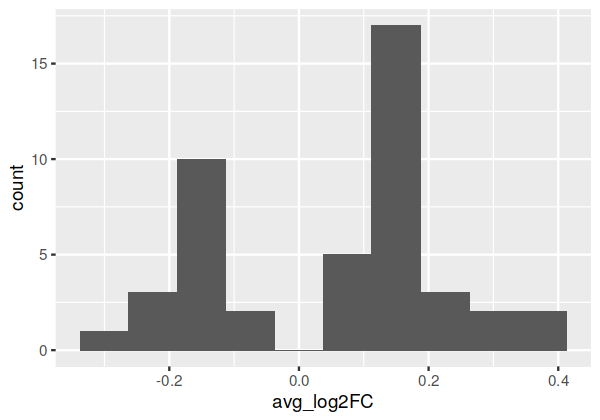

In [38]:
options(repr.plot.width=5, repr.plot.height=3.5)
ggplot(df_neighbor_de, aes(x = avg_log2FC)) +
    geom_histogram(bins=10)

In [39]:
nrow(df_neighbor_de)
head(df_neighbor_de)

[1] 45

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,1.2e-05,-0.20,0.744,0.77,4.3e-01,SEMA4B,ANPEP,tss,Control TSS,1.4e-02
4,1.1e-10,0.37,0.862,0.73,4.1e-06,SNHG5,NT5E,tss,Control TSS,1.4e-07
5,7.2e-09,-0.21,0.669,0.73,2.6e-04,NT5E,NT5E,tss,Control TSS,8.7e-06
6,8.5e-05,-0.10,0.064,0.10,1.0e+00,PTGFR,FUBP1,tss,Control TSS,1.0e-01
8,8.1e-13,-0.17,0.301,0.46,3.0e-08,C15orf40,C15orf40,tss,Control TSS,9.9e-10
9,5.1e-06,0.16,0.959,0.96,1.9e-01,RPS17,C15orf40,tss,Control TSS,6.3e-03


## Volcano Plot

In [40]:
colors <- ifelse(
    df_neighbor_de$subclass == 'tss', 'black',
    ifelse(df_neighbor_de$subclass == 'de_control', 'gray', 'green') 
)
names(colors) <- df_neighbor_de$label

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


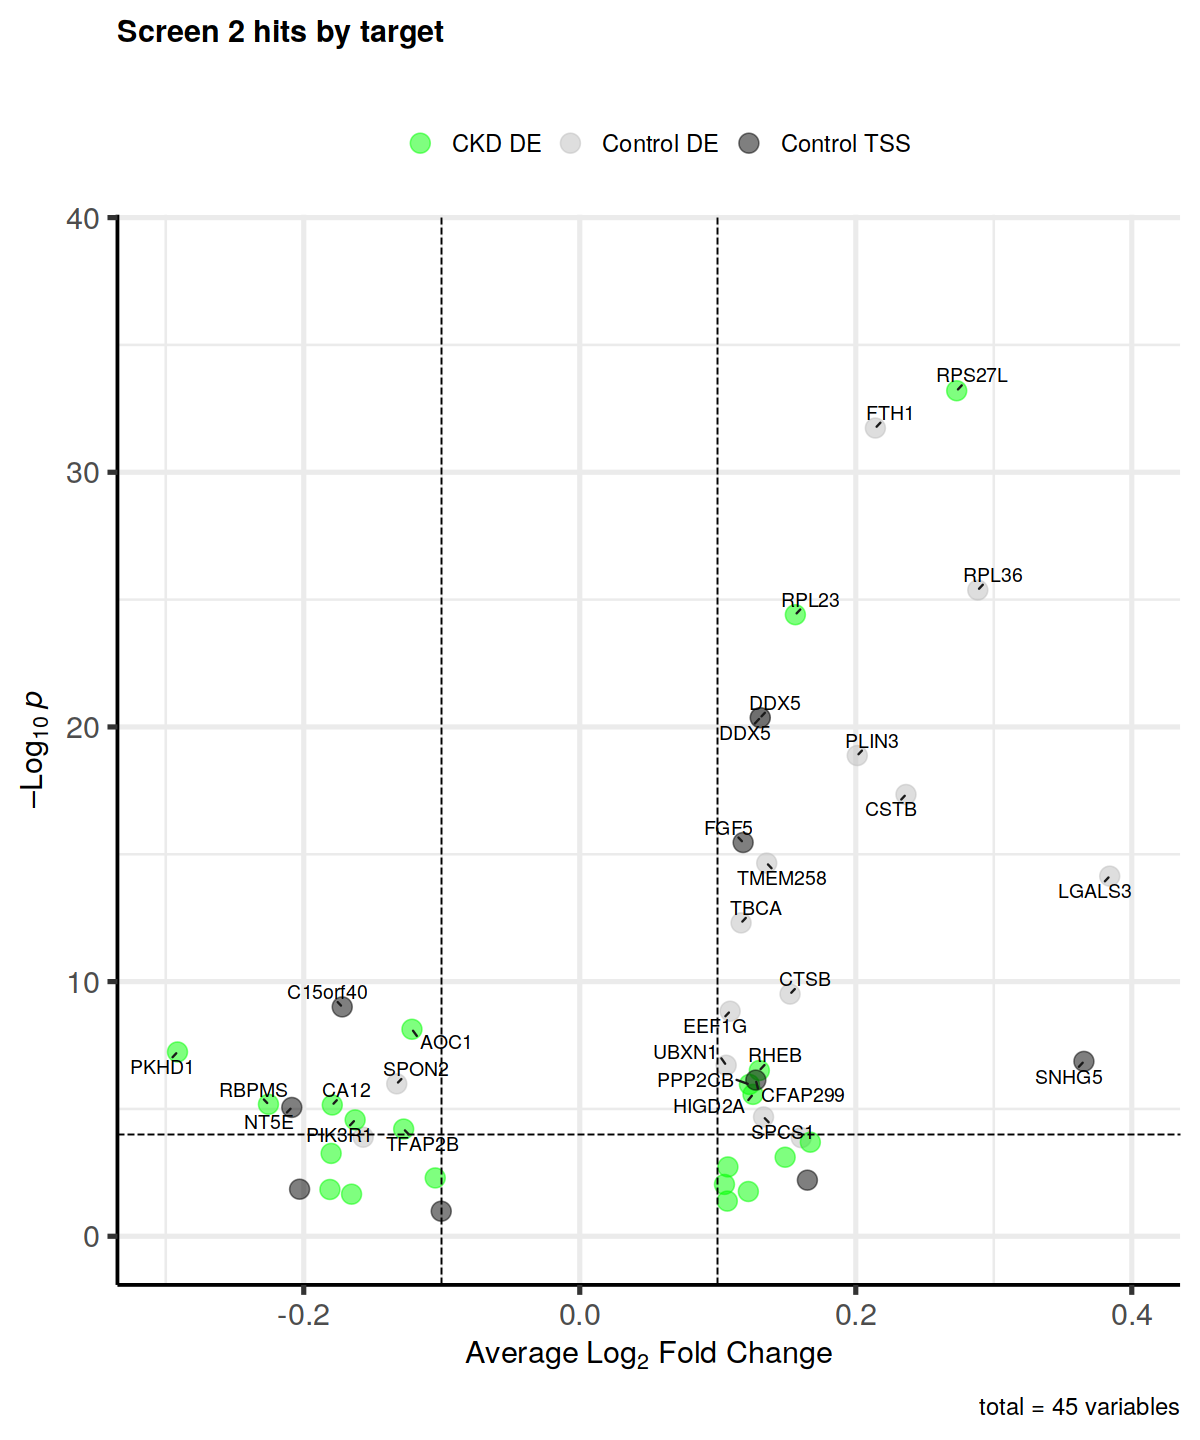

In [66]:
options(repr.plot.width = 10, repr.plot.height = 12)
EnhancedVolcano(df_neighbor_de, 
                lab = df_neighbor_de$de_gene,
                x ="avg_log2FC",
                y ="p_val_adj_mine",
                title = 'Screen 2 hits by target',
                subtitle = '', 
                colCustom = colors,
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-5,
                FCcutoff = 0.1,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-.3, .4) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

# lab = df_neighbor_de$de_gene,
# drawConnectors = TRUE,

### Plot just the control TSS

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


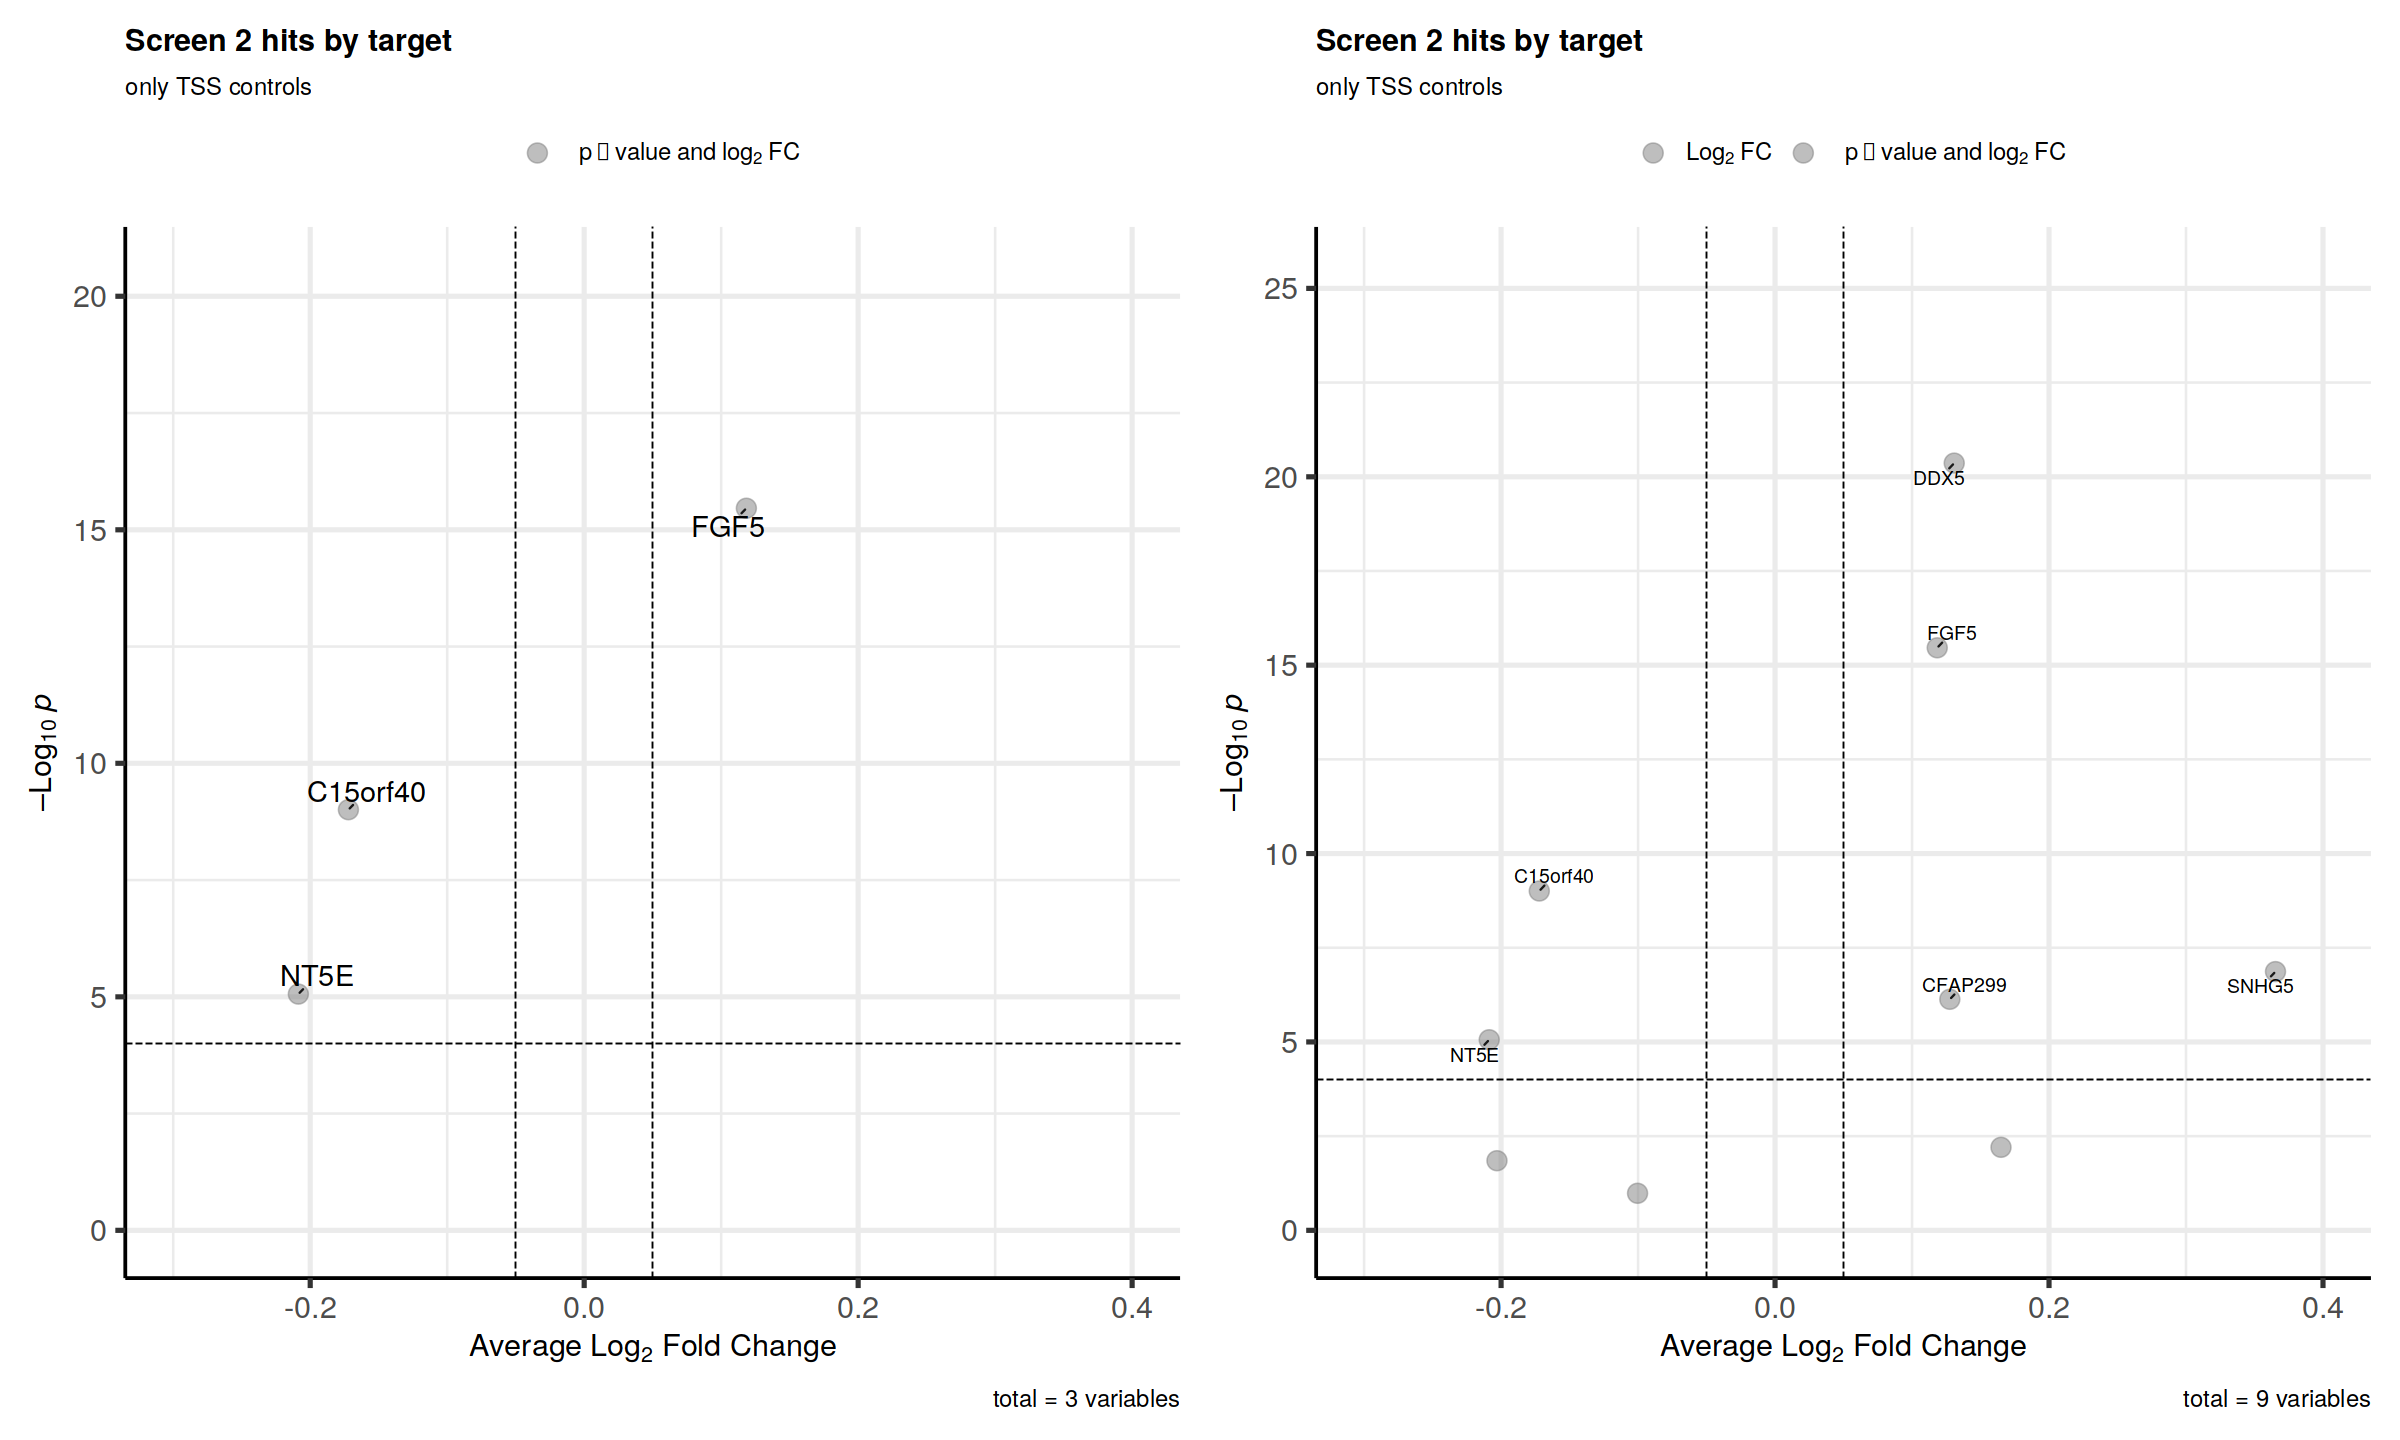

In [88]:
de_filter = (df_neighbor_de$subclass == 'tss') & (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 20, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="avg_log2FC",
                y ="p_val_adj_mine",
                title = 'Screen 2 hits by target',
                subtitle = 'only TSS controls', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-5,
                FCcutoff = 0.05,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-.3, .4) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


de_filter = (df_neighbor_de$subclass == 'tss')
df_neighbor_de_subset = df_neighbor_de[de_filter ,]
p2 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="avg_log2FC",
                y ="p_val_adj_mine",
                title = 'Screen 2 hits by target',
                subtitle = 'only TSS controls', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-5,
                FCcutoff = 0.05,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-.3, .4) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 + p2

In [64]:
df_neighbor_de_subset

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
5,7.2e-09,-0.21,0.67,0.73,2.6e-04,NT5E,NT5E,tss,Control TSS,8.7e-06
8,8.1e-13,-0.17,0.30,0.46,3.0e-08,C15orf40,C15orf40,tss,Control TSS,9.9e-10
49,2.8e-19,0.12,0.24,0.14,1.0e-14,FGF5,FGF5,tss,Control TSS,3.5e-16


### Plot just the control DE

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


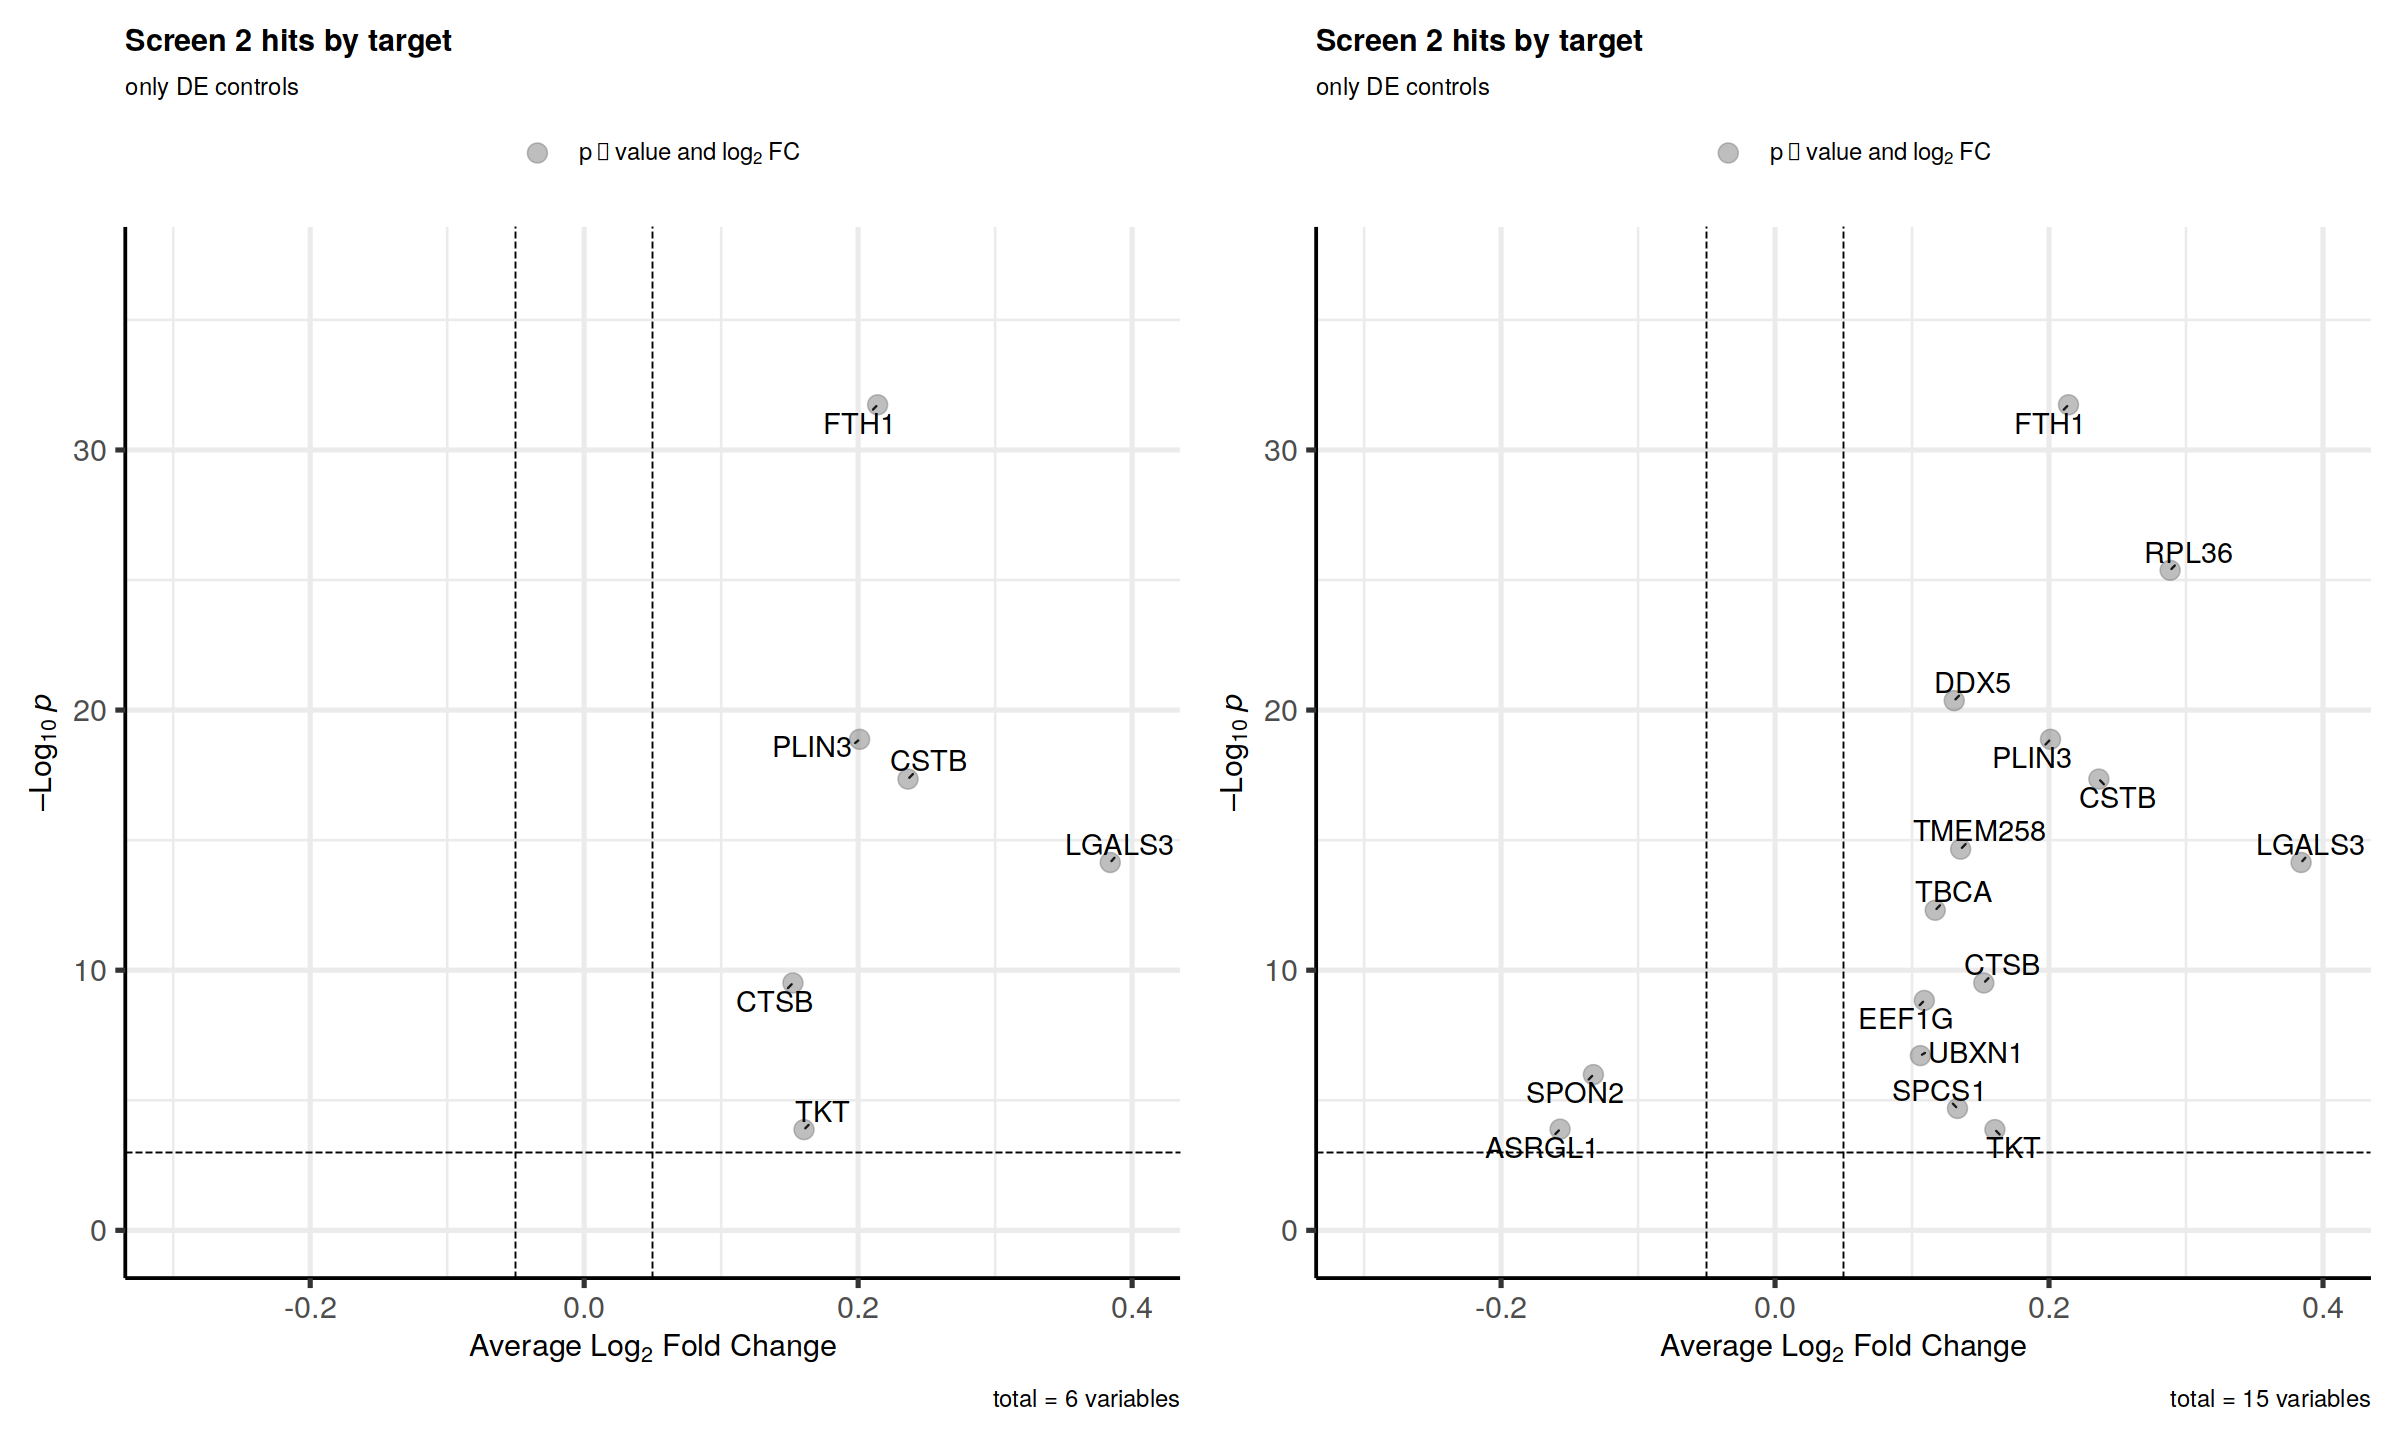

In [86]:
de_filter = (df_neighbor_de$subclass == 'de_control') & (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 20, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="avg_log2FC",
                y ="p_val_adj_mine",
                title = 'Screen 2 hits by target',
                subtitle = 'only DE controls', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-4,
                FCcutoff = 0.05,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-.3, .4) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


de_filter = (df_neighbor_de$subclass == 'de_control')
df_neighbor_de_subset = df_neighbor_de[de_filter ,]
p2 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="avg_log2FC",
                y ="p_val_adj_mine",
                title = 'Screen 2 hits by target',
                subtitle = 'only DE controls', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-4,
                FCcutoff = 0.05,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-.3, .4) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 + p2

### Plot just the CKD DE

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


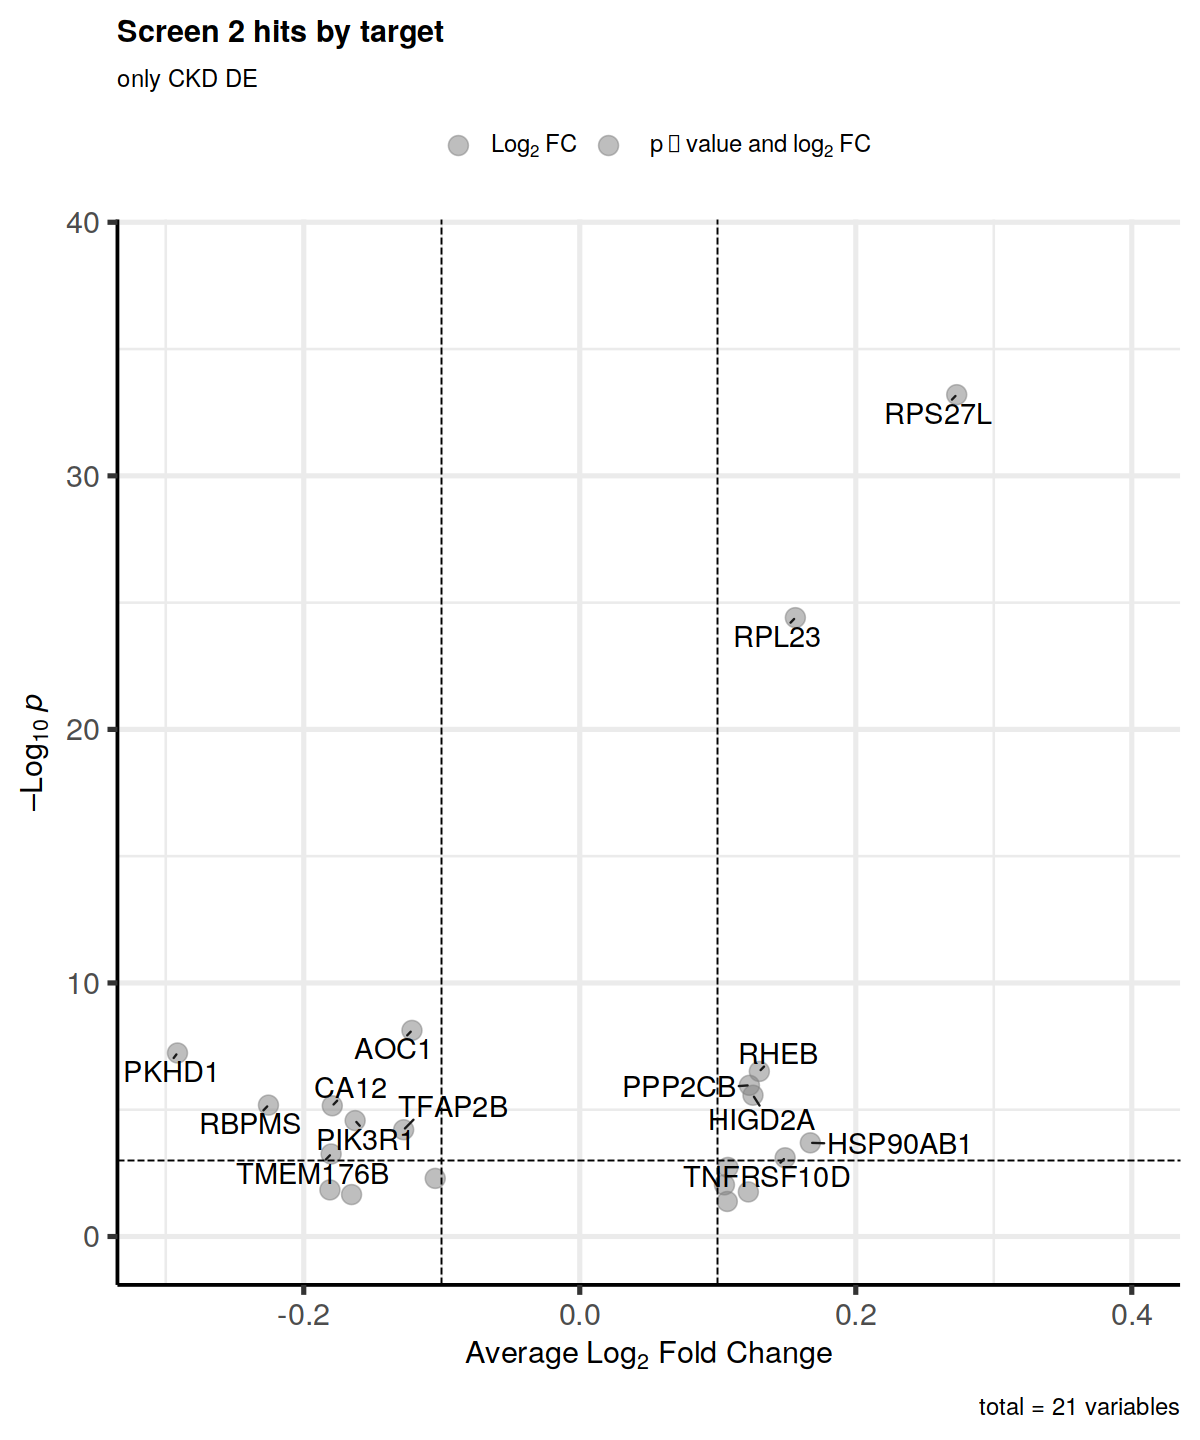

In [98]:
de_filter = (df_neighbor_de$label == 'CKD DE') 
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 10, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="avg_log2FC",
                y ="p_val_adj_mine",
                title = 'Screen 2 hits by target',
                subtitle = 'only CKD DE', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-4,
                FCcutoff = 0.1,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-.3, .4) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 

# Inpect DE results

Print top high-confidence hits

In [59]:
df_neighbor_de %>% filter(avg_log2FC > 0) %>% arrange(p_val_adj_mine) %>% head(10)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,5.2e-37,0.27,0.98,0.96,1.9e-32,RPS27L,DE22,ckd_de,CKD DE,6.3e-34
2,1.5e-35,0.21,1.00,1.00,5.5e-31,FTH1,FTH1,de_control,Control DE,1.8e-32
3,3.5e-29,0.29,0.99,0.98,1.3e-24,RPL36,PLIN3,de_control,Control DE,4.2e-26
4,3.2e-28,0.16,0.99,0.98,1.2e-23,RPL23,DE20,ckd_de_no_rs,CKD DE,3.9e-25
5,3.6e-24,0.13,0.95,0.94,1.3e-19,DDX5,ICAM2,de_control,Control DE,4.3e-21
6,3.6e-24,0.13,0.95,0.94,1.3e-19,DDX5,ICAM2,tss,Control TSS,4.3e-21
7,1.1e-22,0.20,0.72,0.63,4.0e-18,PLIN3,PLIN3,de_control,Control DE,1.3e-19
8,3.7e-21,0.24,0.95,0.93,1.3e-16,CSTB,CSTB,de_control,Control DE,4.5e-18
9,2.8e-19,0.12,0.24,0.14,1.0e-14,FGF5,FGF5,tss,Control TSS,3.5e-16


In [60]:
df_neighbor_de %>% filter((subclass == 'tss')) %>% arrange(p_val_adj_mine) %>% head(30)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,3.6e-24,0.13,0.953,0.94,1.3e-19,DDX5,ICAM2,tss,Control TSS,4.3e-21
2,2.8e-19,0.12,0.242,0.14,1.0e-14,FGF5,FGF5,tss,Control TSS,3.5e-16
3,8.1e-13,-0.17,0.301,0.46,3.0e-08,C15orf40,C15orf40,tss,Control TSS,9.9e-10
4,1.1e-10,0.37,0.862,0.73,4.1e-06,SNHG5,NT5E,tss,Control TSS,1.4e-07
5,6.1e-10,0.13,0.241,0.16,2.2e-05,CFAP299,FGF5,tss,Control TSS,7.4e-07
6,7.2e-09,-0.21,0.669,0.73,2.6e-04,NT5E,NT5E,tss,Control TSS,8.7e-06
7,5.1e-06,0.16,0.959,0.96,1.9e-01,RPS17,C15orf40,tss,Control TSS,6.3e-03
8,1.2e-05,-0.20,0.744,0.77,4.3e-01,SEMA4B,ANPEP,tss,Control TSS,1.4e-02
9,8.5e-05,-0.10,0.064,0.10,1.0e+00,PTGFR,FUBP1,tss,Control TSS,1.0e-01


In [99]:
df_neighbor_de %>% filter((label == 'CKD DE') & (p_val_adj_mine < 0.05)) %>% arrange(p_val_adj_mine) 

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
5.2e-37,0.27,0.981,0.96,1.9e-32,RPS27L,DE22,ckd_de,CKD DE,6.3e-34
3.2e-28,0.16,0.990,0.98,1.2e-23,RPL23,DE20,ckd_de_no_rs,CKD DE,3.9e-25
6.1e-12,-0.12,0.091,0.17,2.2e-07,AOC1,DE17,ckd_de,CKD DE,7.4e-09
4.7e-11,-0.29,0.498,0.58,1.7e-06,PKHD1,DE16,ckd_de,CKD DE,5.8e-08
2.5e-10,0.13,0.873,0.80,9.3e-06,RHEB,DE17,ckd_de,CKD DE,3.1e-07
8.9e-10,0.12,0.801,0.73,3.3e-05,PPP2CB,DE15,ckd_de,CKD DE,1.1e-06
2.2e-09,0.13,0.855,0.80,8.1e-05,HIGD2A,DE19,ckd_de,CKD DE,2.7e-06
5.4e-09,-0.23,0.971,0.97,2.0e-04,RBPMS,DE15,ckd_de,CKD DE,6.6e-06
5.7e-09,-0.18,0.874,0.87,2.1e-04,CA12,DE22,ckd_de,CKD DE,7.0e-06


In [45]:
df_neighbor_de %>% filter((subclass == 'de_control') & (p_val_adj_mine < 1)) %>% arrange(p_val_adj_mine) 

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1.5e-35,0.21,1.00,1.00,5.5e-31,FTH1,FTH1,de_control,Control DE,1.8e-32
3.5e-29,0.29,0.99,0.98,1.3e-24,RPL36,PLIN3,de_control,Control DE,4.2e-26
3.6e-24,0.13,0.95,0.94,1.3e-19,DDX5,ICAM2,de_control,Control DE,4.3e-21
1.1e-22,0.20,0.72,0.63,4.0e-18,PLIN3,PLIN3,de_control,Control DE,1.3e-19
3.7e-21,0.24,0.95,0.93,1.3e-16,CSTB,CSTB,de_control,Control DE,4.5e-18
1.8e-18,0.14,0.87,0.81,6.7e-14,TMEM258,FTH1,de_control,Control DE,2.2e-15
5.9e-18,0.38,0.92,0.86,2.2e-13,LGALS3,LGALS3,de_control,Control DE,7.2e-15
4.1e-16,0.12,0.94,0.92,1.5e-11,TBCA,IQGAP2,de_control,Control DE,5.0e-13
2.5e-13,0.15,0.99,0.96,9.3e-09,CTSB,CTSB,de_control,Control DE,3.1e-10


## Print top hits w/o log FC filtering

In [46]:
targets  = unique(df_neighbor_de$target)
col_list = c('target', 'de_gene', 'avg_log2FC', 'p_val_adj_mine', 'label')
df_top_hits = NULL

for(t in targets){
    df_dummy = filter(df_neighbor_de[, col_list], (target == t)) %>% arrange(p_val_adj_mine) %>% head(2)
    #colnames(df_dummy) = NULL
    if(nrow(df_dummy)>0) {
        #print(df_dummy)
        df_top_hits = rbind(df_top_hits, df_dummy)
    }
    else {
        cat(green("Skipping ", t), "\n")
    }
    #cat(yellow("-----------------------------------------------------------\n\n\n"))
}

In [47]:
#df_top_hits %>% filter(label == "Control TSS")
#df_top_hits %>% filter(label == "Control DE")
df_top_hits %>% filter(label == "CKD DE")

target,de_gene,avg_log2FC,p_val_adj_mine,label
<chr>,<chr>,<dbl>,<dbl>,<chr>
DE3,NRIP1,0.11,1.9e-03,CKD DE
DE4,PIK3R1,-0.16,2.7e-05,CKD DE
DE7,TNFRSF10D,0.15,7.9e-04,CKD DE
DE7,TNFRSF10B,0.11,4.2e-02,CKD DE
DE9,HSP90AB1,0.17,2.0e-04,CKD DE
DE9,DNPH1,0.12,1.7e-02,CKD DE
DE12,G3BP2,0.10,9.2e-03,CKD DE
DE15,PPP2CB,0.12,1.1e-06,CKD DE
DE15,RBPMS,-0.23,6.6e-06,CKD DE


## Print top hits w/ avg LogFC >0

In [48]:
targets  = unique(df_neighbor_de$target)
col_list = c('target', 'de_gene', 'avg_log2FC', 'p_val_adj_mine', 'label')
df_top_hits = NULL

for(t in targets){
    df_dummy = filter(df_neighbor_de[, col_list], (target == t) & (avg_log2FC > 0)) %>% arrange(p_val_adj_mine) %>% head(2)
    #colnames(df_dummy) = NULL   
    if(nrow(df_dummy)>0) {
        #print(df_dummy)
        df_top_hits = rbind(df_top_hits, df_dummy)
    }
    else {
        cat(green("Skipping ", t), "\n")
    }
    #cat(yellow("-----------------------------------------------------------\n\n\n"))
}

Skipping  ANPEP 
Skipping  FUBP1 
Skipping  DE4 
Skipping  DE16 
Skipping  DE21 
Skipping  DE23 
Skipping  FGFR3 


In [49]:
df_top_hits %>% filter(label == "CKD DE")

target,de_gene,avg_log2FC,p_val_adj_mine,label
<chr>,<chr>,<dbl>,<dbl>,<chr>
DE3,NRIP1,0.11,1.9e-03,CKD DE
DE7,TNFRSF10D,0.15,7.9e-04,CKD DE
DE7,TNFRSF10B,0.11,4.2e-02,CKD DE
DE9,HSP90AB1,0.17,2.0e-04,CKD DE
DE9,DNPH1,0.12,1.7e-02,CKD DE
DE12,G3BP2,0.10,9.2e-03,CKD DE
DE15,PPP2CB,0.12,1.1e-06,CKD DE
DE17,RHEB,0.13,3.1e-07,CKD DE
DE19,HIGD2A,0.13,2.7e-06,CKD DE


# Visualize Knockdowns

## TSS controls

[1] "ANPEP"
CD13-1a   323 
CD13-1b   433 
Guide+ = 433 ; Guide- = 45618 
[1] "CD55"
CD55-1a   244 
CD55-1b   364 
Guide+ = 364 ; Guide- = 45687 
[1] "NT5E"
CD73-1a   289 
CD73-1b   399 
Guide+ = 399 ; Guide- = 45652 
[1] "FUBP1"
FUBP1-1a   191 
FUBP1-1b   313 
Guide+ = 313 ; Guide- = 45738 
[1] "C15orf40"
C15orf40-1a   305 
C15orf40-1b   415 
Guide+ = 415 ; Guide- = 45636 
[1] "MAFF"
MAFF-1a   232 
MAFF-1b   321 
Guide+ = 321 ; Guide- = 45730 
[1] "UMOD"
UMOD-1a   740 
UMOD-1b   1018 
Guide+ = 1018 ; Guide- = 45033 
[1] "SLC34A1"
SLC34A1-1a   410 
SLC34A1-1b   583 
Guide+ = 583 ; Guide- = 45468 
[1] "BDKRB2"
BDKRB2-1a   651 
BDKRB2-1b   886 
Guide+ = 886 ; Guide- = 45165 
[1] "ICAM2"
ICAM2-1a   902 
ICAM2-2a   1488 
ICAM2tss-1a   2204 
ICAM2-1b   2438 
ICAM2-2b   2595 
ICAM2tss-1b   2806 
Guide+ = 2806 ; Guide- = 43245 
[1] "FGF5"
FGF5-1a   778 
FGF5-1b   1018 
Guide+ = 1018 ; Guide- = 45033 


$`1`

$`2`

attr(,"class")
[1] "list"      "ggarrange"

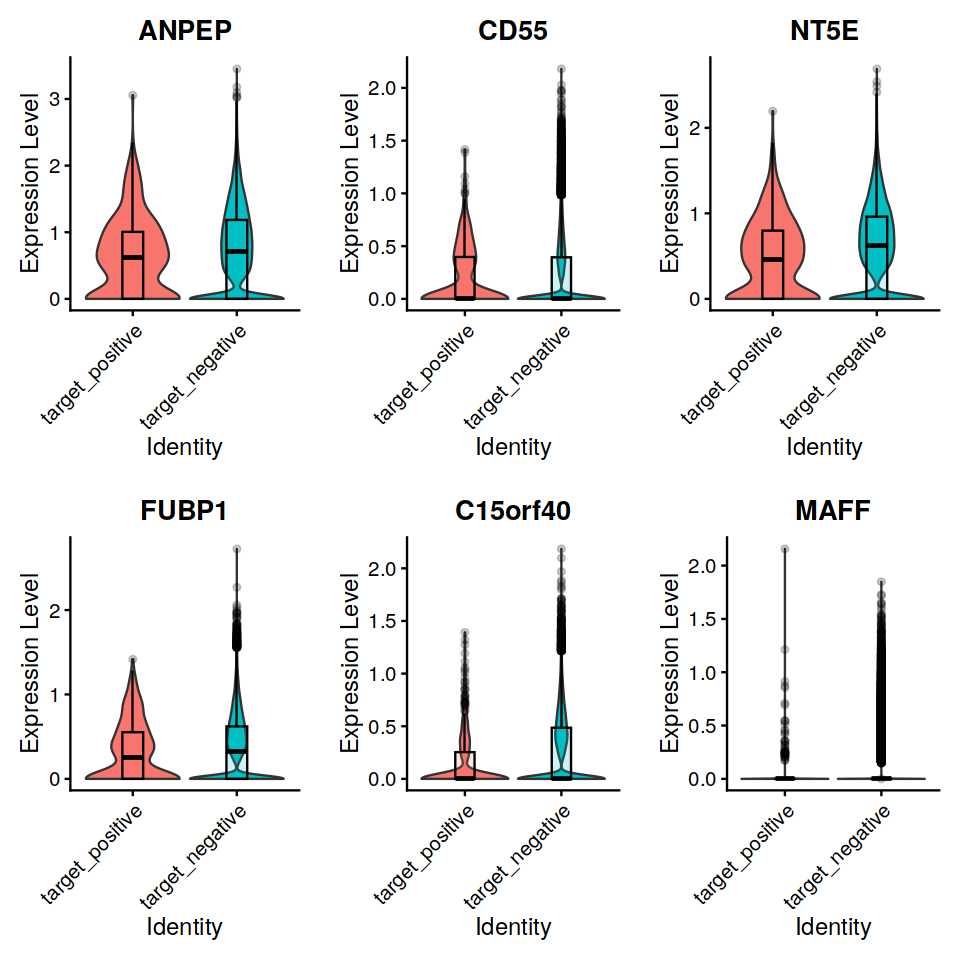

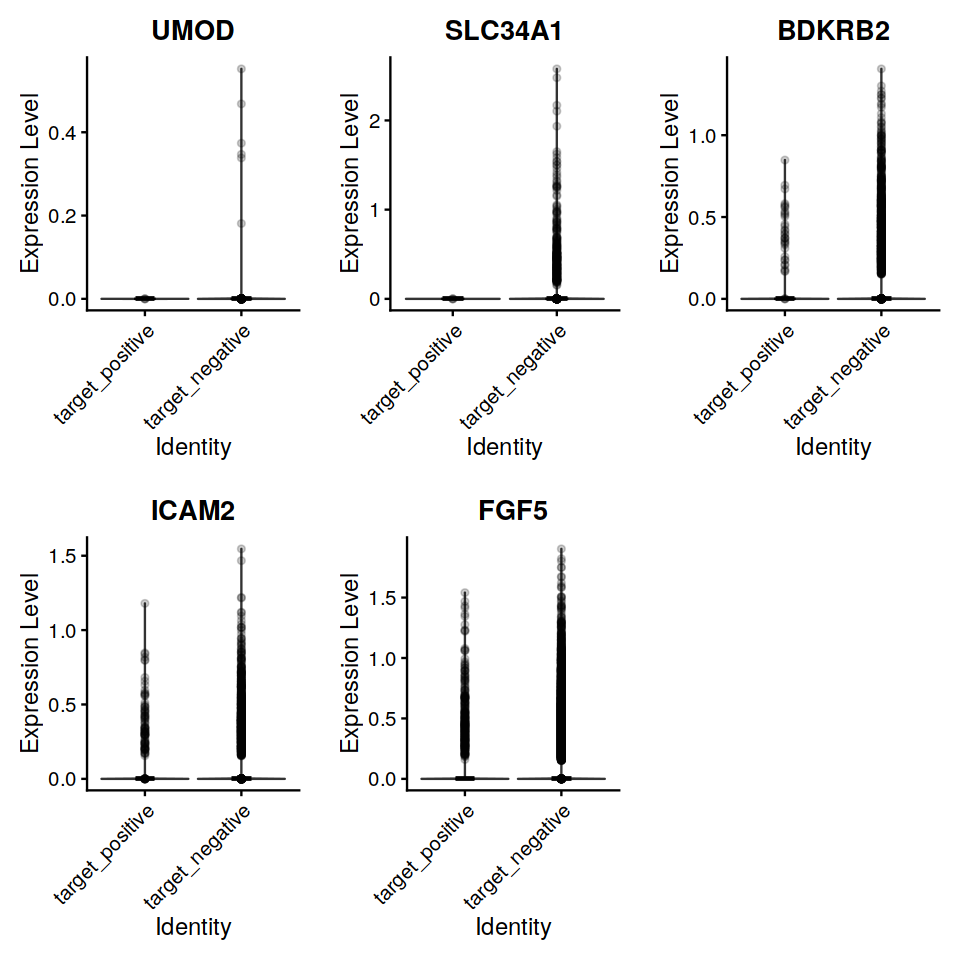

In [50]:
targets = unique(filter(df_guide, subclass=='tss')$alias)
plots = vlnplot_for_targets(seurat_rna, df_guide, perturbed_cells_by_guide, targets)
options(repr.plot.width=8, repr.plot.height=8)
ggarrange(plotlist=plots, ncol=3, nrow = 2)

## DE controls

[1] "FTH1"
FTH1-1a   175 
FTH1-2a   1339 
FTH1-1b   1404 
FTH1-2b   1404 
Guide+ = 1404 ; Guide- = 44647 
[1] "PLIN3"
PLIN3-1a   289 
PLIN3-2a   524 
PLIN3-1b   620 
PLIN3-2b   715 
Guide+ = 715 ; Guide- = 45336 
[1] "TKT"
TKT-1a   290 
TKT-2a   546 
TKT-1b   665 
TKT-2b   765 
Guide+ = 765 ; Guide- = 45286 
[1] "LGALS3"
LGALS3-1a   330 
LGALS3-2a   597 
LGALS3-1b   696 
LGALS3-2b   782 
Guide+ = 782 ; Guide- = 45269 
[1] "CSTB"
CSTB-1a   334 
CSTB-2a   671 
CSTB-1b   792 
CSTB-2b   862 
Guide+ = 862 ; Guide- = 45189 
[1] "CTSB"
CTSB-1a   288 
CTSB-2a   562 
CTSB-1b   657 
CTSB-2b   730 
Guide+ = 730 ; Guide- = 45321 
[1] "KLF6"
KLF6-1a   303 
KLF6-2a   636 
KLF6-1b   737 
KLF6-2b   822 
Guide+ = 822 ; Guide- = 45229 
[1] "IQGAP2"
IQGAP2-1a   583 
IQGAP2-2a   1195 
IQGAP2-1b   1505 
IQGAP2-2b   1801 
Guide+ = 1801 ; Guide- = 44250 
[1] "FGFR3"
FGFR3-1a   538 
FGFR3-2a   1311 
FGFR3-1b   1578 
FGFR3-2b   1751 
Guide+ = 1751 ; Guide- = 44300 
[1] "HIST1H4H"
HIST1H4H-1a   247 
HIST1H4H-2a

$`1`

$`2`

attr(,"class")
[1] "list"      "ggarrange"

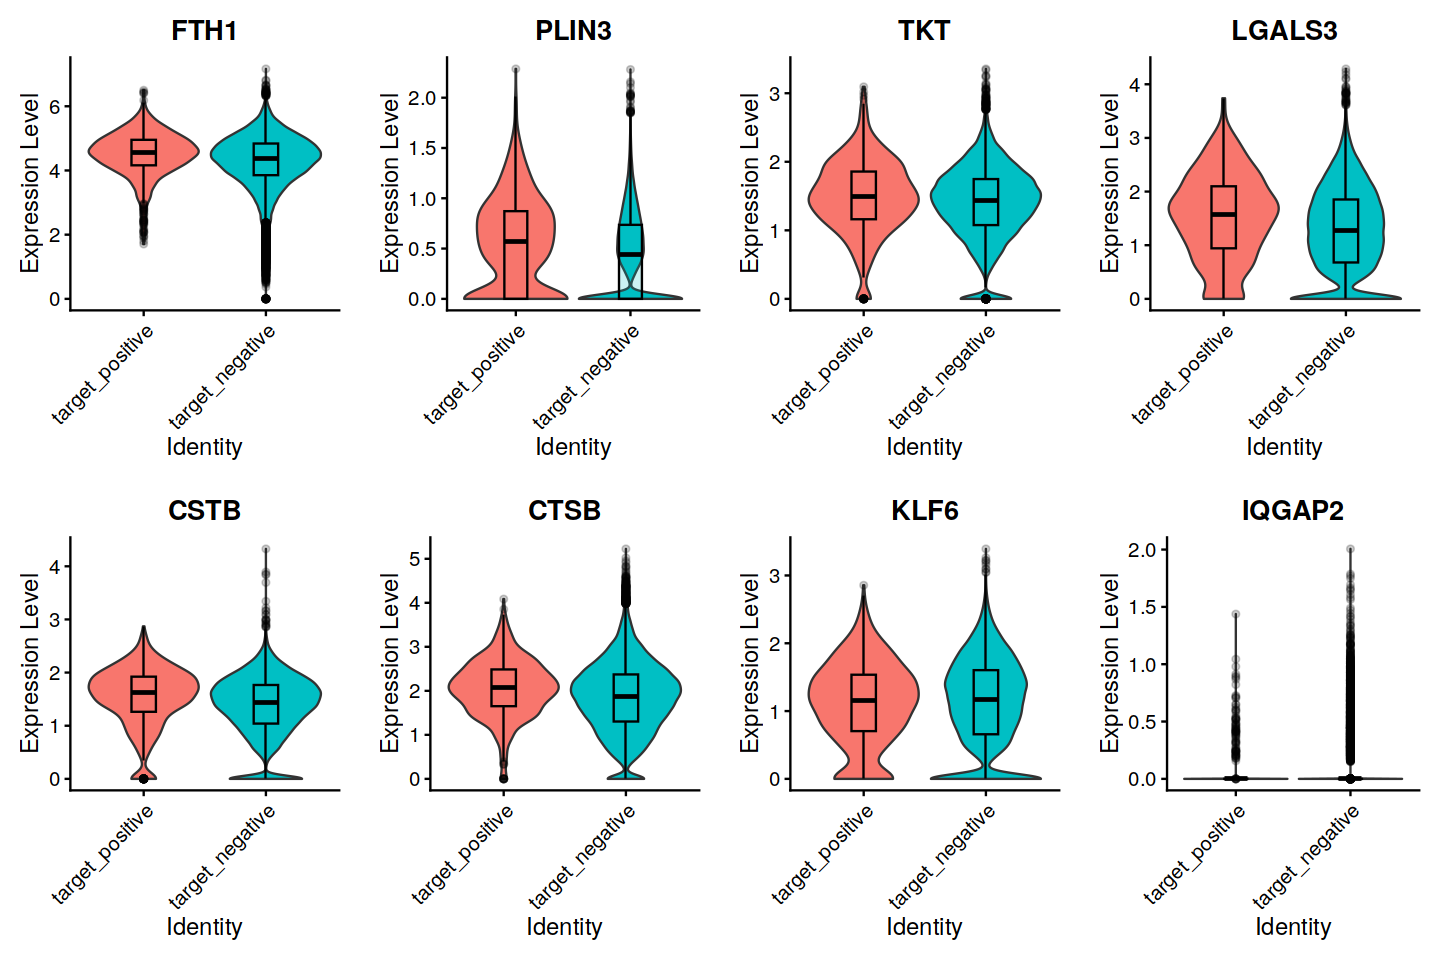

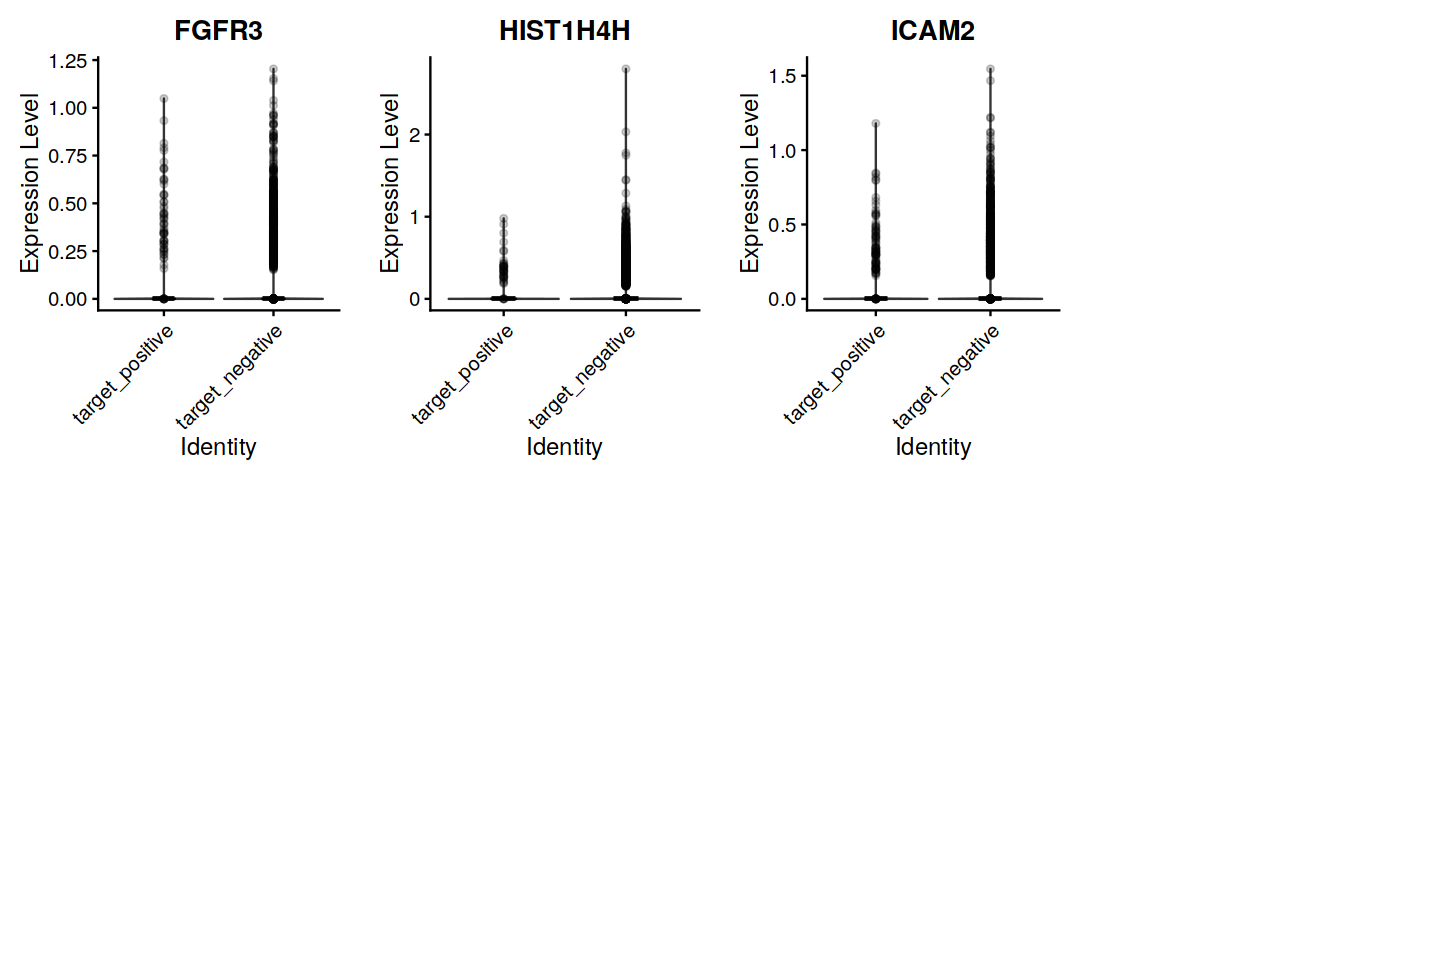

In [51]:
targets = unique(filter(df_guide, subclass=='de_control')$alias)
plots = vlnplot_for_targets(seurat_rna, df_guide, perturbed_cells_by_guide, targets)
options(repr.plot.width=12, repr.plot.height=8)
ggarrange(plotlist=plots, ncol=4, nrow = 2)

## CKD DE 

[1] "DE22"


Guide+ = 1712 ; Guide- = 44339 
[1] "DE15"
Guide+ = 798 ; Guide- = 45253 


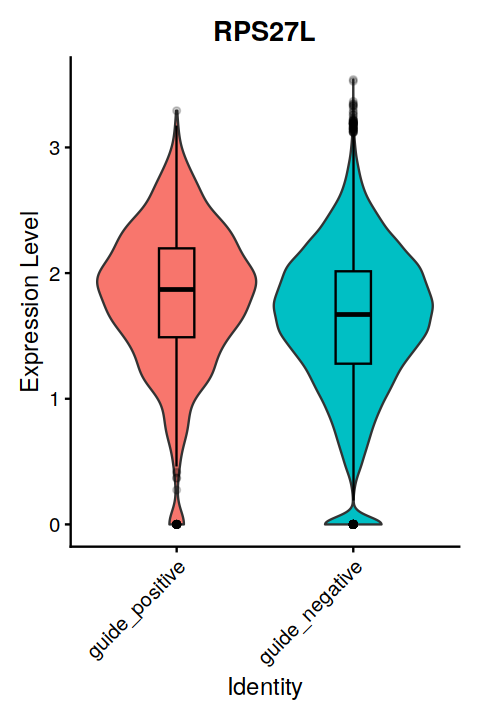

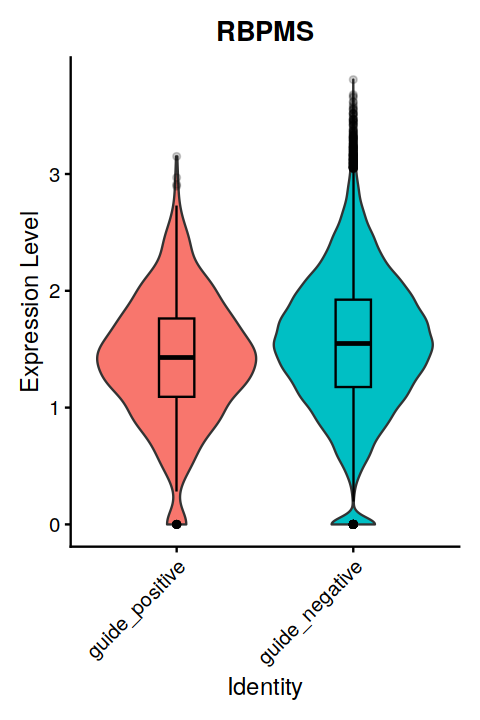

In [52]:
target = "DE22"
regulated_gene = "RPS27L"
print(target)
guides = get_guides_by_subclass(df_guide, 'alias', target)
seurat_rna <- mark_guide_pos_neg(
    seurat_rna, 
    perturbed_cells_by_guide, 
    guides, 
    print_counts = T
)

plt1 <- VlnPlot(
    object = seurat_rna,
    features = regulated_gene, 
    idents = NULL, 
    pt.size = 0, 
    sort = F, 
    ncol = 1,    
) +
geom_boxplot(width=0.2, color="black", alpha=0.2) + 
theme(legend.position = 'none', plot.subtitle = element_text(hjust = 0.5))     



target = "DE15"
regulated_gene = "RBPMS"
print(target)
guides = get_guides_by_subclass(df_guide, 'alias', target)
seurat_rna <- mark_guide_pos_neg(
    seurat_rna, 
    perturbed_cells_by_guide, 
    guides, 
    print_counts = T
)

plt2 <- VlnPlot(
    object = seurat_rna,
    features = regulated_gene, 
    idents = NULL, 
    pt.size = 0, 
    sort = F, 
    ncol = 1,    
) +
geom_boxplot(width=0.2, color="black", alpha=0.2) + 
theme(legend.position = 'none', plot.subtitle = element_text(hjust = 0.5))     

options(repr.plot.width=4, repr.plot.height=6)
print(plt1) 
print(plt2)

### Violin plots for all DEs

In [53]:
vlnplot_for_de_targets <- function(seurat_obj, df_guide, perturbed_cells_by_guide, df_target_vs_regulated) {
    plt_list = list()
    for(i in 1:nrow(df_target_vs_regulated)) {
        target = df_target_vs_regulated[i, 'target']
        regulated_gene = df_target_vs_regulated[i, 'de_gene']
        my_p_val = df_target_vs_regulated[i, 'p_val_adj_mine']
        my_p_val = formatC(my_p_val, format = "e", digits = 1)
        title = paste0(target, ": ", regulated_gene)
        subtitle = paste("Adjusted p =", my_p_val)
        
        guides = get_guides_by_subclass(df_guide, 'alias', target)
        seurat_dummy <- mark_target_pos_neg(
            seurat_rna,
            perturbed_cells_by_guide, 
            guides, 
            print_counts = F
        )

        options(repr.plot.width=5, repr.plot.height=4)
        plt <- VlnPlot(
            object = seurat_dummy,
            features =  regulated_gene, 
            idents = NULL, 
            pt.size = 0., 
            sort = F, 
            ncol = 1,    
        ) + 
            geom_boxplot(width=.2, color="black", alpha=0.2) + theme(legend.position = 'none') +
            labs(title = title, subtitle = subtitle)
        plt_list[[i]] = plt
    }
    plt_list
}


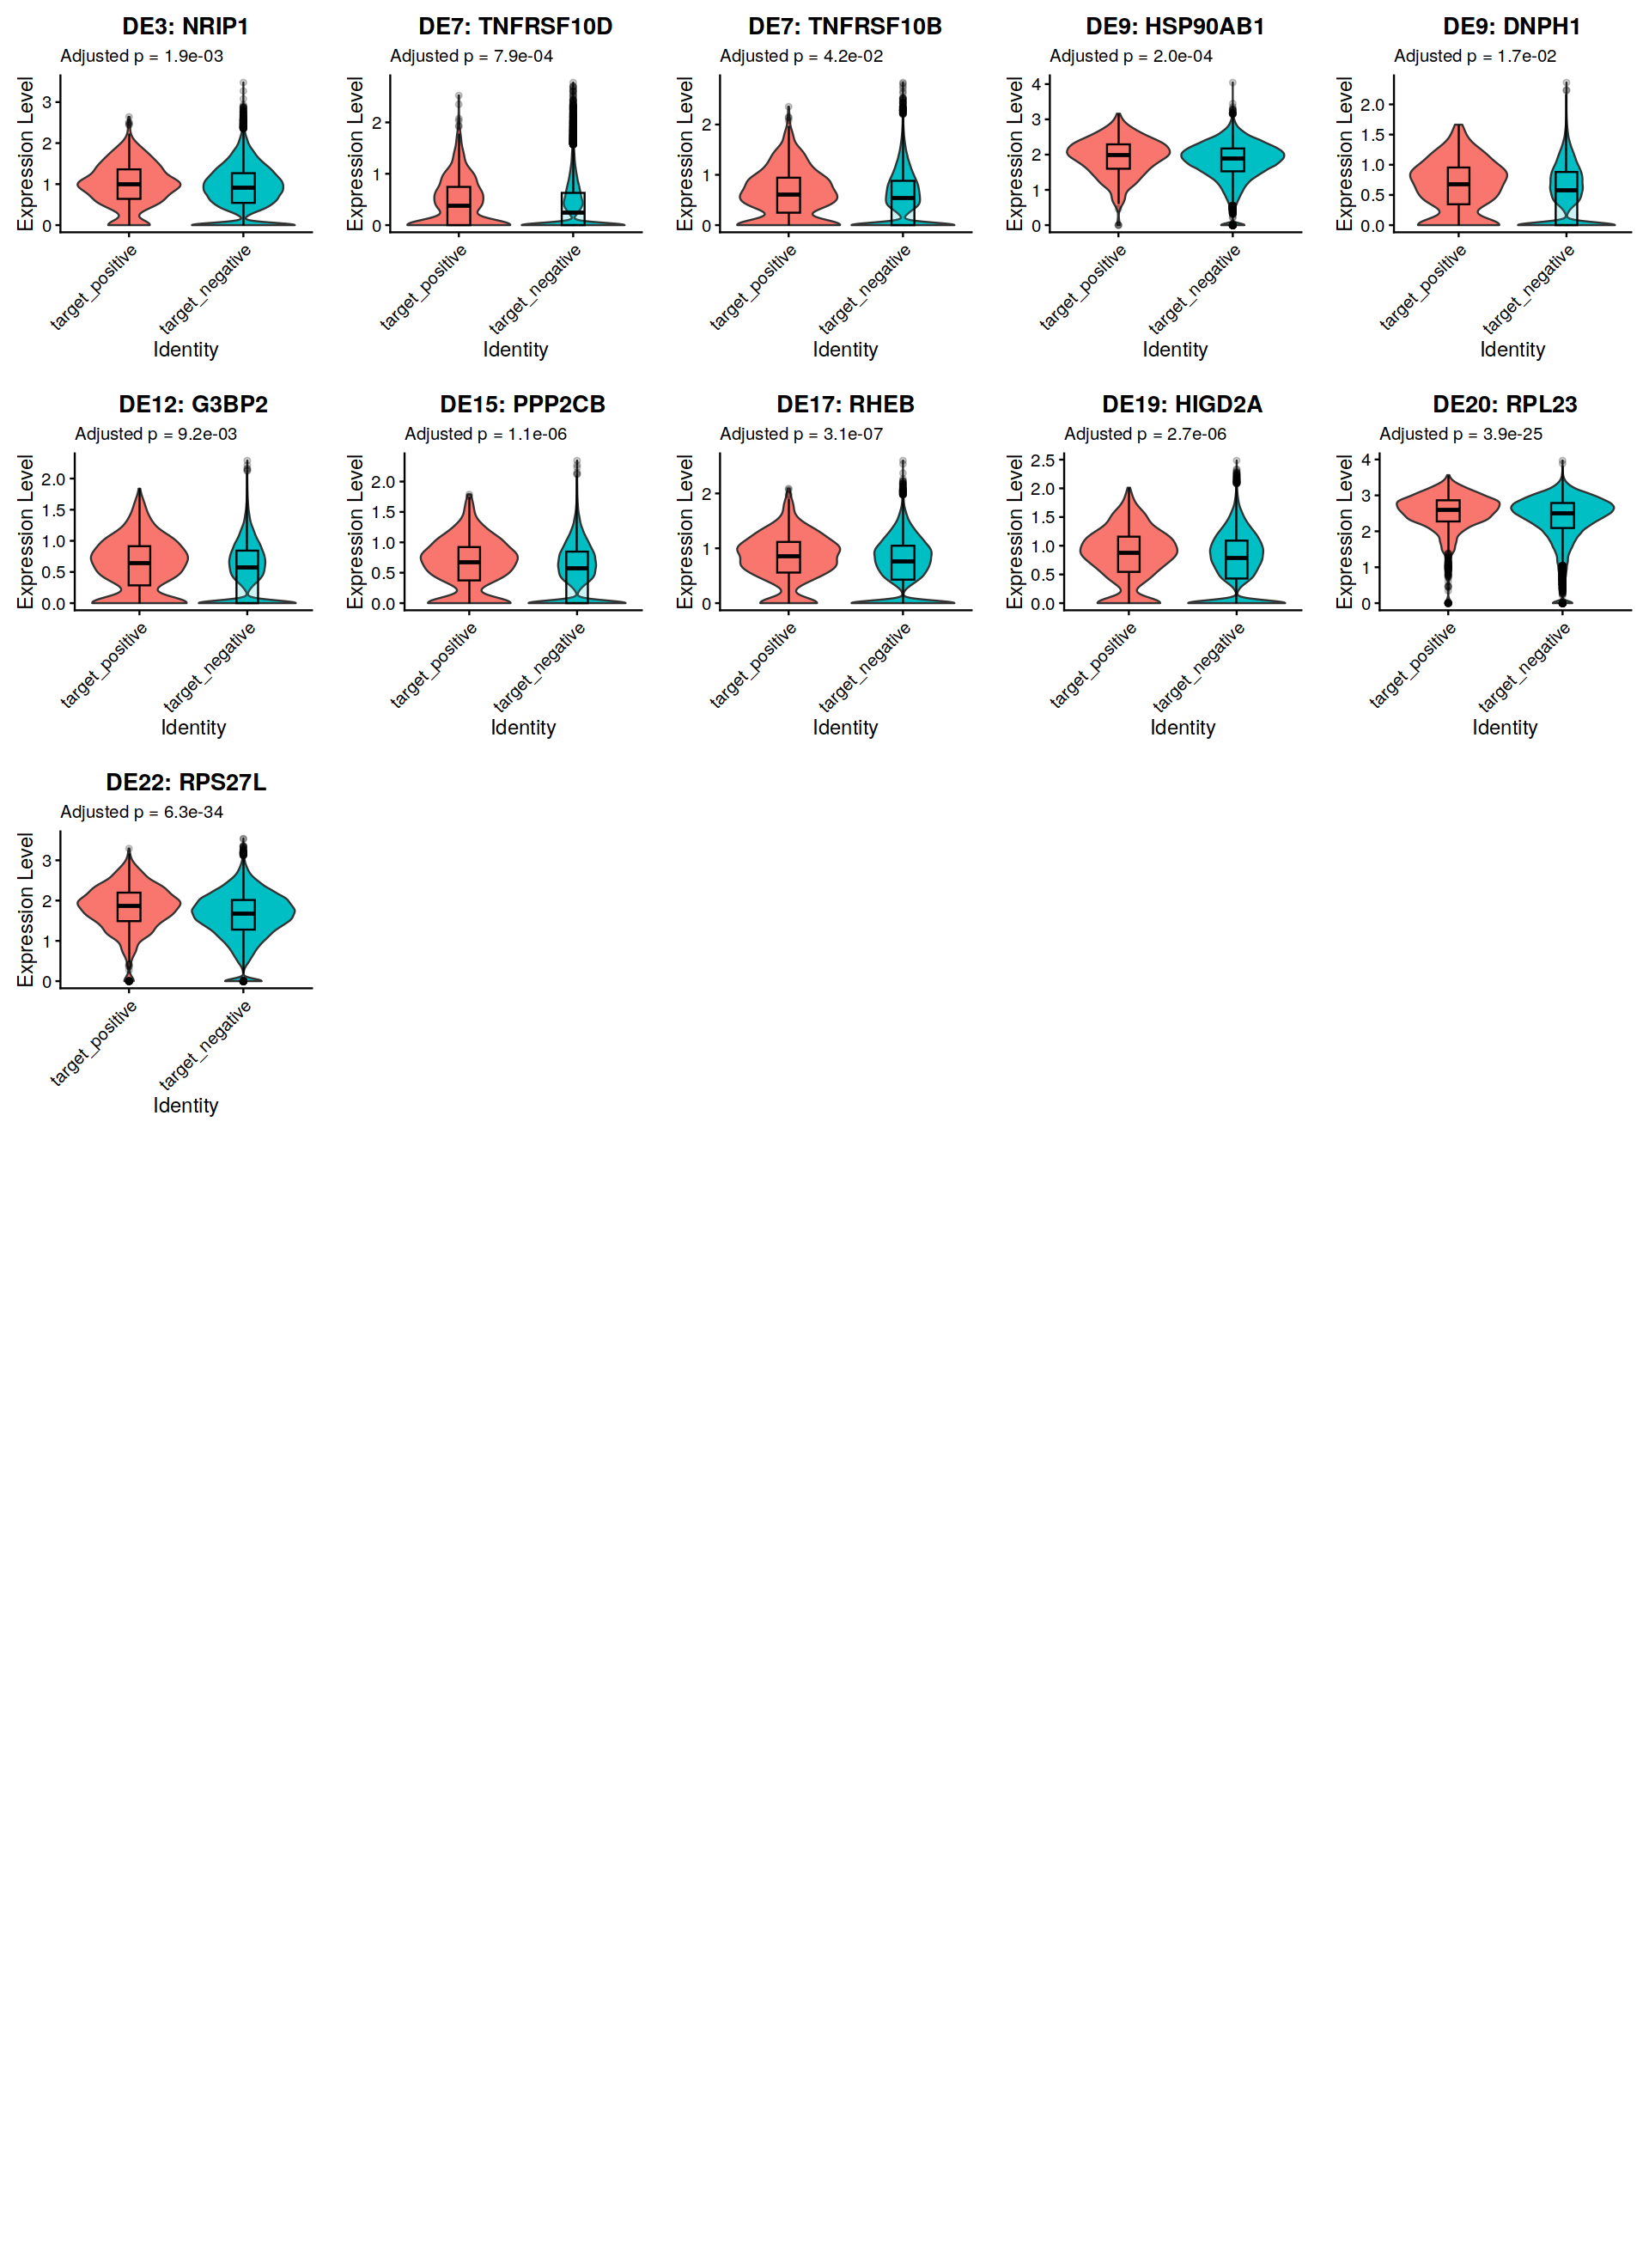

In [54]:
df_top_distal_hits = df_top_hits %>% filter(label == "CKD DE")
df_target_vs_regulated = df_top_hits %>% filter(label == "CKD DE")
plots = vlnplot_for_de_targets(seurat_rna, df_guide, perturbed_cells_by_guide, df_top_distal_hits)

options(repr.plot.width=16, repr.plot.height=22)
ggarrange(plotlist=plots, ncol=5, nrow = 6)


# Debug

In [ ]:
target = "DE6"
regulated_gene = "NDRG1"
print(target)
guides = get_guides_by_subclass(df_guide, 'alias', target)
seurat_rna <- mark_guide_pos_neg(
    seurat_rna, 
    perturbed_cells_by_guide, 
    guides, 
    print_counts = T
)

[1] "DE6"


Guide+ = 1263 ; Guide- = 44788 


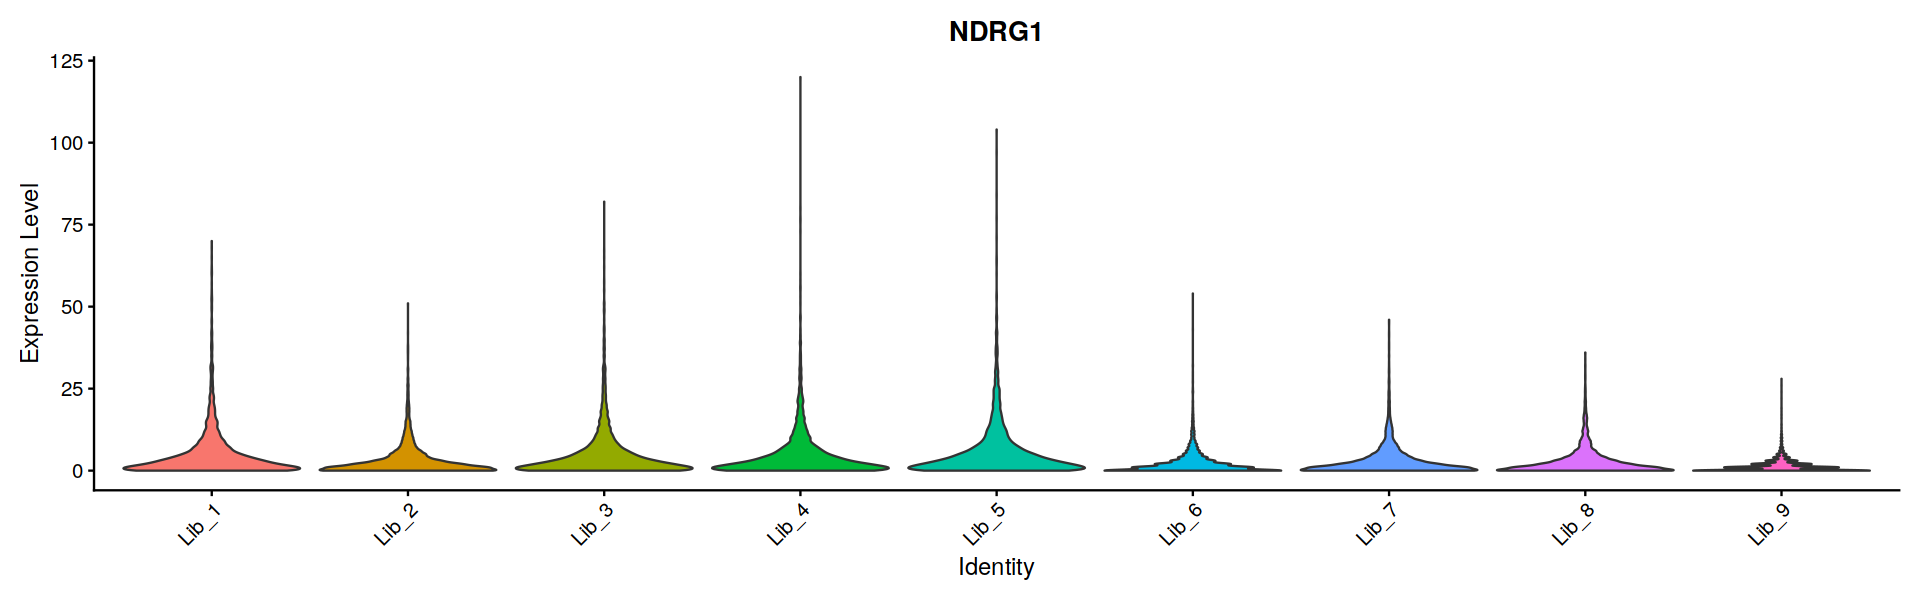

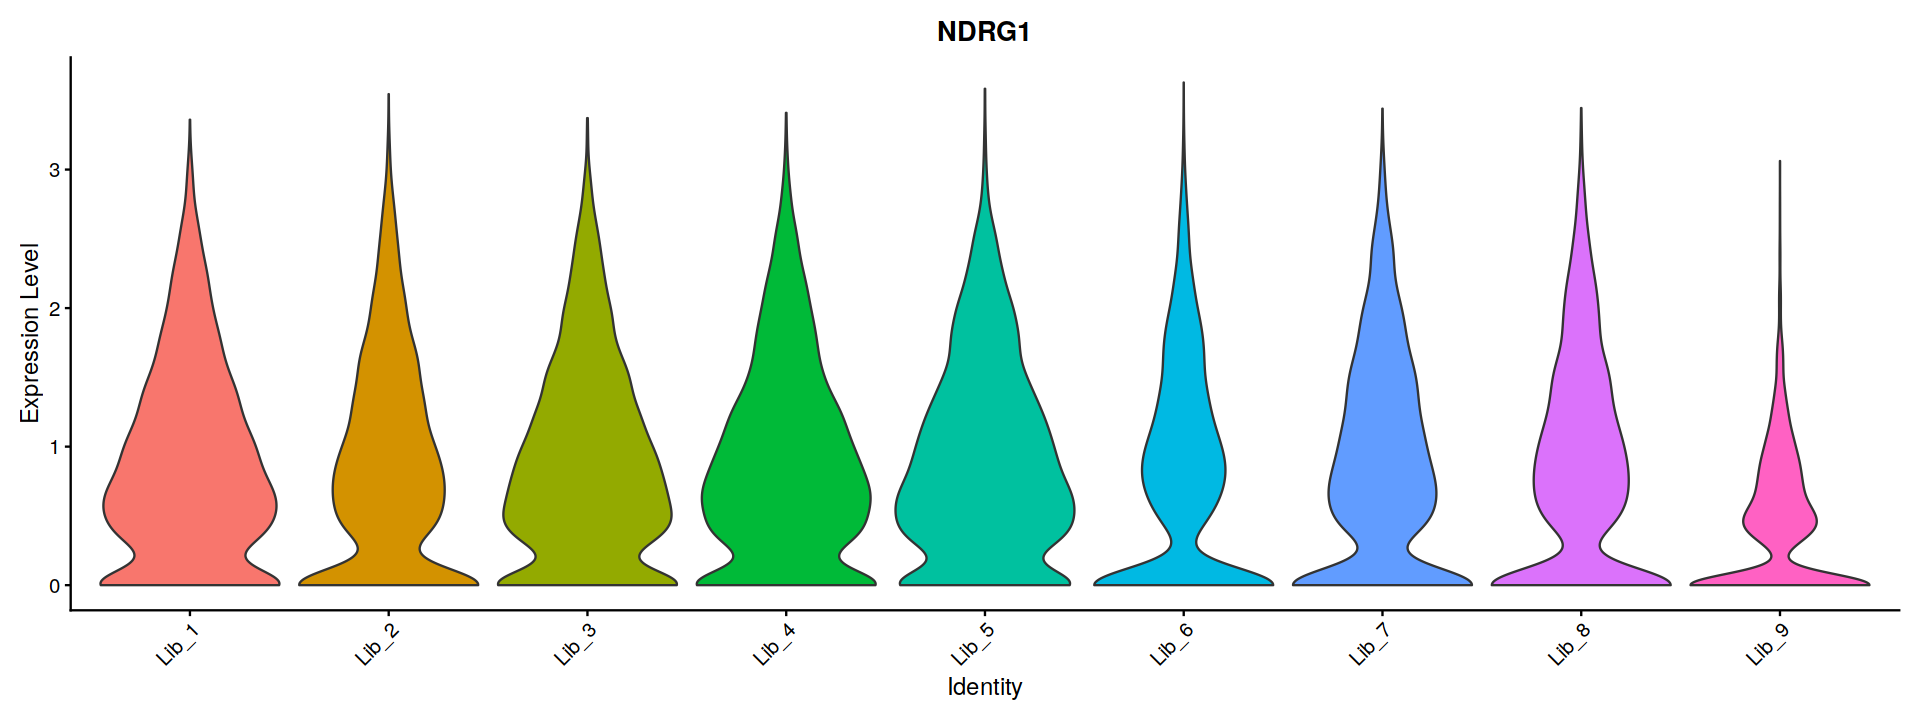

In [133]:
options(repr.plot.width=16, repr.plot.height=5)
VlnPlot(
    object = seurat_rna,
    idents = "guide_negative",
    slot = 'counts',
    features = c("NDRG1"),
    pt.size = 0.,
    group.by = 'library',
  ) +  theme(legend.position="none")

options(repr.plot.width=16, repr.plot.height=6)
VlnPlot(
    object = seurat_rna,
    idents = "guide_negative",
    slot = 'data',
    features = c("NDRG1"),
    pt.size = 0,
    group.by = 'library'
  ) +  theme(legend.position="none")


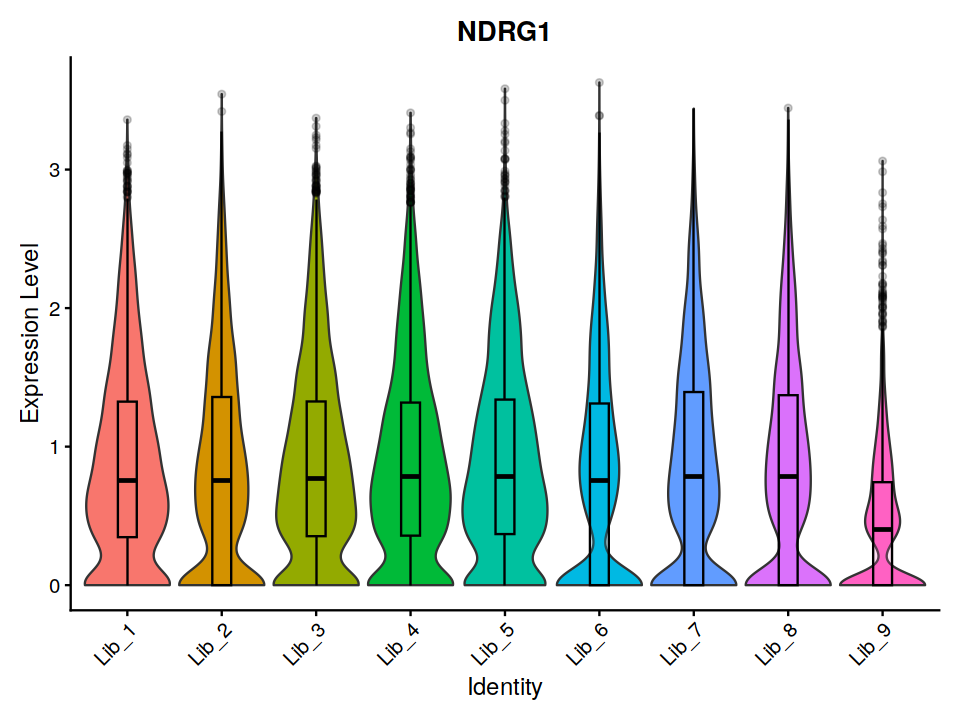

In [134]:
plt1 <- VlnPlot(
    object = seurat_rna,
    features = regulated_gene, 
    ident = 'guide_negative',
    slot = 'data', 
    pt.size = 0, 
    sort = F, 
    ncol = 1,
    group.by = 'library',
) +
geom_boxplot(width=0.2, color="black", alpha=0.2) + 
theme(legend.position = 'none', plot.subtitle = element_text(hjust = 0.5))     

options(repr.plot.width=8, repr.plot.height=6)
plt1

In [135]:
target = "DE15"
regulated_gene = "RBPMS"
print(target)
guides = get_guides_by_subclass(df_guide, 'alias', target)
seurat_rna <- mark_guide_pos_neg(
    seurat_rna, 
    perturbed_cells_by_guide, 
    guides, 
    print_counts = T
)

plt2 <- VlnPlot(
    object = seurat_rna,
    features = regulated_gene, 
    idents = NULL, 
    pt.size = 0, 
    sort = F, 
    ncol = 1,    
) +
geom_boxplot(width=0.2, color="black", alpha=0.2) + 
theme(legend.position = 'none', plot.subtitle = element_text(hjust = 0.5))     

options(repr.plot.width=4, repr.plot.height=6)
print(plt2)

[1] "DE15"
Guide+ = 798 ; Guide- = 45253 
